This notebook converts the epik microscopic results to type II populations

In [11]:
import os
os.environ["OE_LICENSE"] = "C:\\Users\\rustenba\\Downloads\\oe_license.txt"

from openeye import oechem
import openeye
import oenotebook as oenb
import csv

from pathlib import Path
import pandas as pd
import numpy as np

if not openeye.OEChemIsLicensed():
    raise RunTimeError("Can't find a valid OpenEye license")

### Loading microstates from SAMPL6 files

SAMPL6 microstate definitions are loaded into a dictionary using `load_microstate_dictionary`.

By default it uses from the files at www.github.com/MobleyLab/SAMPL6 , a local copy is stored in the microstates folder.

The states are read in as smiles. For a proper comparison of microstates, explicit hydrogens are added to the molecules using the `add_h` function.



In [2]:
def add_h(mol: oechem.OEMol):
    """Add explicit hydrogens to a molecule"""
    for atom in mol.GetAtoms():
        oechem.OEAddExplicitHydrogens(mol, atom)

def load_microstate_dictionary(sampl_id: str, microstate_folder: str= "./microstates/"):
    """Load a dictionary of microstates as defined by SAMPL from the microstate files.
    
    Parameters
    ----------
    sampl_id - the identifier for the molecule in sampl, e.g. SM12 
    
    Returns
    -------
    dict - key : microstate_id, value : oe_mol
    """

    microstates = dict()

    # Locate the file containing state definitions
    filename = "{}_microstates.csv".format(sampl_id)
    full_path = os.path.join(microstate_folder, filename)
    mypath = Path(full_path)
    if not mypath.is_file():
        raise ValueError("No microstate definitions were found for molecule {}. Check for typos.".format(sampl_id))
    
    # SAMPL6 CSV files are not OpenEye compatible, so instead we read the csv line by line and translate the smiles.
    with open(full_path, 'r') as csvfile:
        csvreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
        
        for row in csvreader:
            key = row['microstate ID']
            val = oechem.OEGraphMol()
            oechem.OESmilesToMol(val, row['canonical isomeric SMILES'])
            add_h(val)
            microstates[key] = val
            
    return microstates

### Loading results from Epik

This function loads the results for a single SAMPL6 molecule at a single pH function. By default it uses
the `output/microscopic` folder, which contains pKa predictions between 2.0 and 12.0 for states with a population of > $e^{-10 RT}$

In [3]:
def load_result(sampl_id:str, pH_str: str, epik_output_folder:str="./output/microscopic/"):
    """Load a single result from Epik files using SAMPL ID, string of the pH with 1 decimal point.
    
    Returns
    -------
    list - OEMols with SD tags containing epik information, every OEMol represents one microstate
    """
    results = list()
        
    
    # Locate the file containing state definitions
    filename = "{}.epik.{}.sdf".format(sampl_id, pH_str)
    full_path = os.path.join(epik_output_folder, sampl_id, filename)
    mypath = Path(full_path)
    if not mypath.is_file():
        raise ValueError("No result file was found for molecule {} at pH {}. Check for typos.".format(sampl_id, pH_str))
    
    ifs = oechem.oemolistream()
    
    if ifs.open(full_path):
        if not oechem.OEIsSDDataFormat(ifs.GetFormat()):
            raise IOError("No SD data")
    
        # Need graphmols for SDF loading
        for mol in ifs.GetOEGraphMols():
            #add_h(mol)
            newmol = oechem.OEGraphMol(mol)
            results.append(newmol)
            # print(newmol.HasSDData())

        ifs.close()
    else:
        raise IOError("Could not read input file.")
    return results

In [4]:
def are_equal_microstates(mol1: oechem.OEGraphMol, mol2: oechem.OEGraphMol, verbose: bool=False):
    """ Check if two supplied OE(Graph)Mol objects have the same molecular microstate present.
    
    If all atoms and bonds are matched in MCSS returns True. Ignores charges and bond order
    to deal with chirality and geometry differences as well as resonance structures
    (which we won't consider as different).
    
    Returns
    -------
    bool    
    """
    # Copy input
    pattern = oechem.OEGraphMol(mol1) 
    target = oechem.OEGraphMol(mol2)
    
    # Atoms are equal if they have same atomic number (so explicit Hydrogens are needed as well for a match)
    atomexpr = oechem.OEExprOpts_AtomicNumber&oechem.OEExprOpts_HCount
     # single or double bonds are considered identical (resonance,chirality fix)
    bondexpr = oechem.OEExprOpts_EqSingleDouble
    # create maximum common substructure object
#     mcss = oechem.OEMCSSearch(pattern, atomexpr, bondexpr, oechem.OEMCSType_Exhaustive)
    mcss = oechem.OEMCSSearch(pattern, atomexpr, bondexpr, oechem.OEMCSType_Approximate)

    
    # set scoring function
    mcss.SetMCSFunc(oechem.OEMCSMaxAtomsCompleteCycles())
    # ignore matches smaller than 6 atoms
    mcss.SetMinAtoms(6)
    unique = True


    # loop over matches
    count = 0
    match = oechem.OEMol()
    for i, match in enumerate(mcss.Match(target, unique)):
        count = i + 1
        if verbose:
            print("Match %d:" % (count))
    
            print( "Num atoms in match %d" % match.NumAtoms())
            print( "Num atoms in mol1 %d" % pattern.NumAtoms())
            print( "Num atoms in mol2 %d" % target.NumAtoms())


    # check if there is only single match
    if (count > 1):
        if verbose: print("Warning! There are multiple matches.")
    elif count == 0:
        if verbose: print("No match")
        
    m_num = match.NumAtoms()
    p_num = pattern.NumAtoms()
    t_num = target.NumAtoms()
        
        
    return m_num == p_num == t_num


def match_subset(pattern: oechem.OEGraphMol, target:oechem.OEGraphMol):
    """Check if target is a subset of pattern."""
    # Atoms are equal if they have same atomic number (so explicit Hydrogens are needed as well for a match)
    atomexpr = oechem.OEExprOpts_AtomicNumber
     # single or double bonds are considered identical (resonance,chirality fix)
    bondexpr = oechem.OEExprOpts_EqSingleDouble
    ss = oechem.OESubSearch(pattern, atomexpr, bondexpr )
    oechem.OEPrepareSearch(target, ss)

    return ss.SingleMatch(target)

def match_microstates(mol1, mol2):
    """If both states are contained in each other, they're the same."""
    return match_subset(mol1, mol2) and match_subset(mol2, mol1)

# Testing


# electrons shifted for benzene
mol1 = oechem.OEMol()
oechem.OESmilesToMol(mol1, "C1=C[CH-]=CC=[CH+]1")
add_h(mol1)

# regular benzene
mol2 = oechem.OEMol()
oechem.OESmilesToMol(mol2, "c1ccccc1")
add_h(mol2)

# protonated benzene
mol3 = oechem.OEMol()
oechem.OESmilesToMol(mol3, "C1=C[CH2-]=CC=[C+]1")
add_h(mol3)


if not match_microstates(mol1, mol2,):
    raise RuntimeError("These should be resonance structures")

if not match_microstates(mol2, mol1, ):
    raise RuntimeError("Order should not matter.")

if match_microstates(mol1, mol3, ):
    raise RuntimeError("These should not be equal states.")

if match_microstates(mol2, mol3, ):
    raise RuntimeError("These should not be equal states either.")

In [5]:
def map_result(microstates: dict, results: list):
    """Match states from results at one pH to microstates."""
    matches, unmatched = [], []
    for index, result_state in enumerate(results):
        mapping = {"Epik_Microstate": "{:d}".format(index),
                   "Epik_Molecule": result_state, "SMILES" : oechem.OECreateCanSmiString(result_state)}
        matched = False
        for microstate_id, microstate in microstates.items():
            newmatch = match_microstates(result_state, microstate)
            if newmatch and matched:
#                 print(index, microstate_id, "matched more than once!")
                duplicate_mapping = dict(mapping)
                duplicate_mapping["SAMPL6_Microstate_ID"] = microstate_id
                duplicate_mapping["SAMPL6_Molecule"] = microstate                
                matches.append(duplicate_mapping)
            elif newmatch:
                matched = True
#                 print(index, microstate_id, "matched!")
                mapping["SAMPL6_Microstate_ID"] = microstate_id
                mapping["SAMPL6_Molecule"] = microstate
                matches.append(mapping)
                
        if matched == False:
#             print("Could not match: ", index)
            unmatched.append(mapping)
    return matches, unmatched

In [6]:
unmatched_states = pd.DataFrame(columns=["Epik_Microstate", "Epik_Molecule", "pH", "SAMPL6_ID", "SAMPL6_Microstate_ID", "SAMPL6_Molecule"])
matched_states = pd.DataFrame(columns=["Epik_Microstate", "Epik_Molecule", "pH", "SAMPL6_ID", "SAMPL6_Microstate_ID", "SAMPL6_Molecule"])

for molecule in range(24):
    SAMPL_ID = "SM{:02d}".format(molecule+1)
    print(SAMPL_ID)
    microstates = load_microstate_dictionary(SAMPL_ID)
    for pH in np.linspace(2.0, 12.0, 101):
        if pH % 2.0 == 0:
            print(pH)
        pH_str = '{:.1f}'.format(pH)
        results = load_result(SAMPL_ID, pH_str)        
        matched, unmatched = map_result(microstates, results)
        for um in unmatched:
            um['pH'] = pH_str
            um['SAMPL6_ID'] = SAMPL_ID
            unmatched_states = unmatched_states.append(um, ignore_index=True)
        for m in matched:
            m['pH'] = pH_str
            m['SAMPL6_ID'] = SAMPL_ID
            matched_states = matched_states.append(m, ignore_index=True)

SM01
2.0
4.0
6.0
8.0
10.0
12.0
SM02
2.0
4.0
6.0
8.0
10.0
12.0
SM03
2.0
4.0
6.0
8.0
10.0
12.0
SM04
2.0
4.0
6.0
8.0
10.0
12.0
SM05
2.0
4.0
6.0
8.0
10.0
12.0
SM06
2.0
4.0
6.0
8.0
10.0
12.0
SM07
2.0
4.0
6.0
8.0
10.0
12.0
SM08
2.0
4.0
6.0
8.0
10.0
12.0
SM09
2.0
4.0
6.0
8.0
10.0
12.0
SM10
2.0
4.0
6.0
8.0
10.0
12.0
SM11
2.0
4.0
6.0
8.0
10.0
12.0
SM12
2.0
4.0
6.0
8.0
10.0
12.0
SM13
2.0
4.0
6.0
8.0
10.0
12.0
SM14
2.0
4.0
6.0
8.0
10.0
12.0
SM15
2.0
4.0
6.0
8.0
10.0
12.0
SM16
2.0
4.0
6.0
8.0
10.0
12.0
SM17
2.0
4.0
6.0
8.0
10.0
12.0
SM18
2.0
4.0
6.0
8.0
10.0
12.0
SM19
2.0
4.0
6.0
8.0
10.0
12.0
SM20
2.0
4.0
6.0
8.0
10.0
12.0
SM21
2.0
4.0
6.0
8.0
10.0
12.0
SM22
2.0
4.0
6.0
8.0
10.0
12.0
SM23
2.0
4.0
6.0
8.0
10.0
12.0
SM24
2.0
4.0
6.0
8.0
10.0
12.0


In [159]:
# Epik states that don't match a state in SAMPL6
# These may just be too exotic/unrealistic, they dont look sensible
unmatched_states_filtered = unmatched_states.drop(["pH", "SAMPL6_Microstate_ID", "SAMPL6_Molecule"], 1).drop_duplicates("SMILES")
unmatched_states['Log_P'] = unmatched_states.apply(lambda row: np.float(oechem.OEGetSDData(row['Epik_Molecule'],"r_epik_State_Penalty"))/ (-298.15 * 1.9872036e-3), axis=1)
# For matched states, retrieve log P data. 
matched_states['Log_P'] = matched_states.apply(lambda row: np.float(oechem.OEGetSDData(row['Epik_Molecule'],"r_epik_State_Penalty"))/ (-298.15 * 1.9872036e-3), axis=1)

Some states generated by Epik were not matches with the molecules in SAMPL6, ignoring these in the analysis


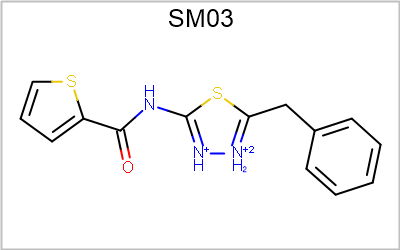
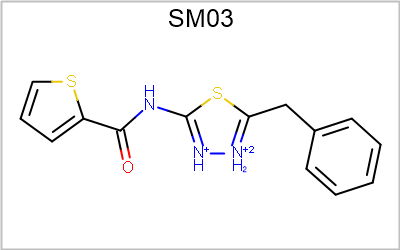
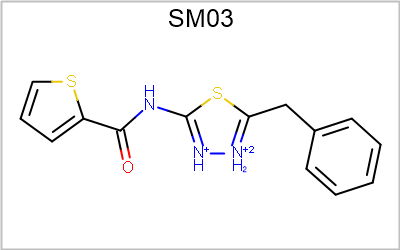
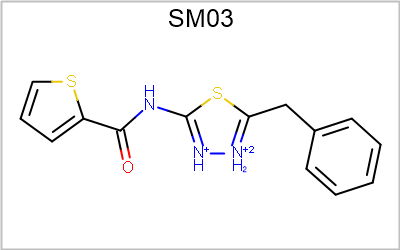
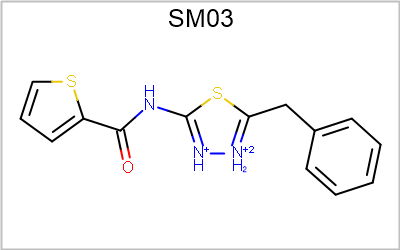
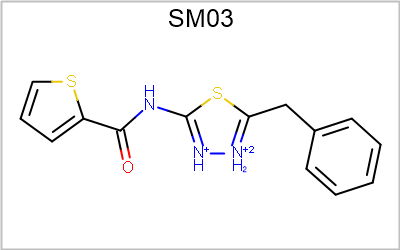
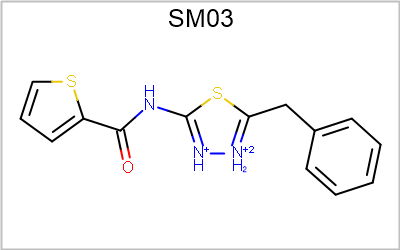
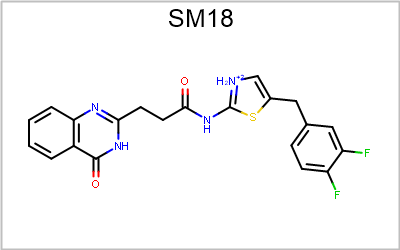

In [160]:
oenb.render_dataframe(unmatched_states, mol_col="Epik_Molecule")

In [11]:
#oenb.render_dataframe(matched_states[matched_states["SAMPL6_ID"]== "SM02"], mol_col="Epik_Molecule")

Duplicated by SAMPL 0
Duplicated by Epik 540
Duplicated states with different tautomer energy: 92



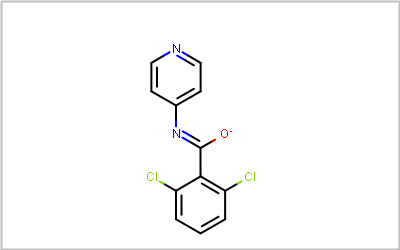
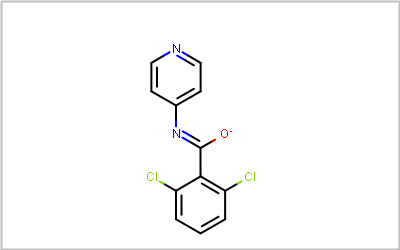
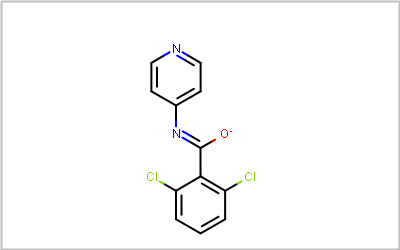
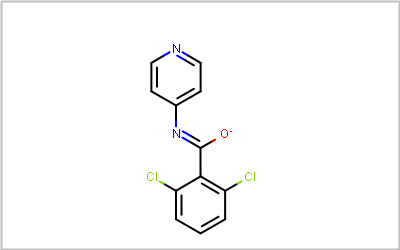
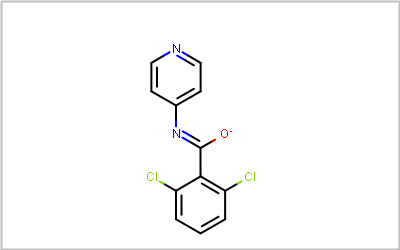
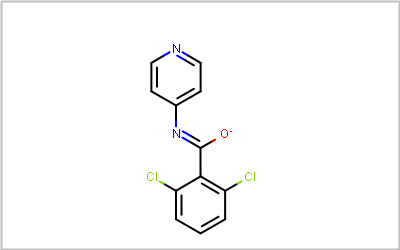
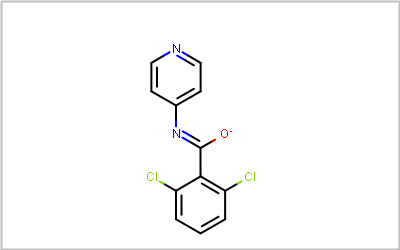
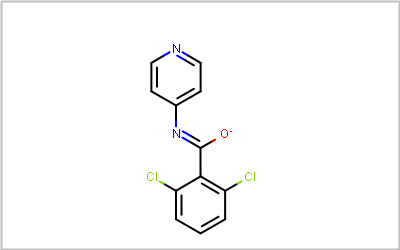
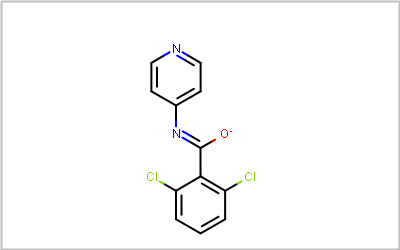
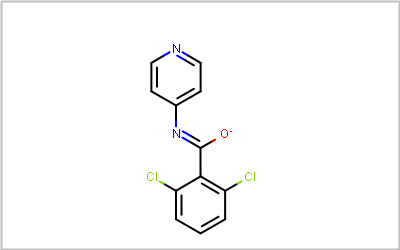
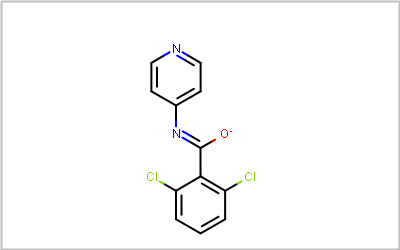
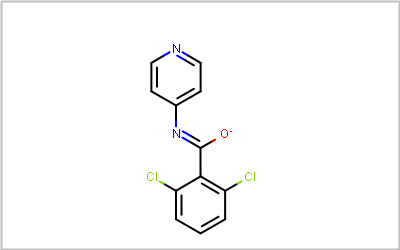
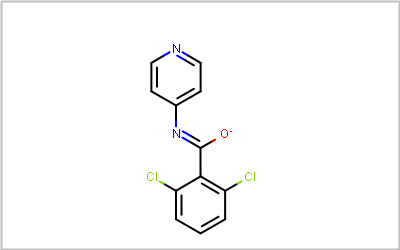
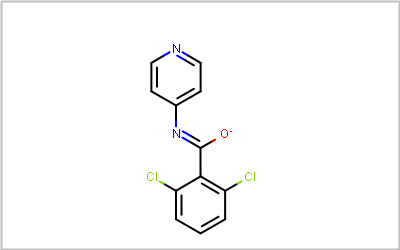
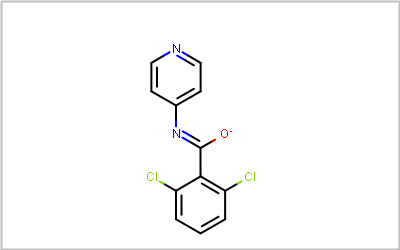
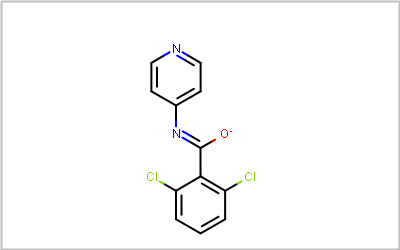
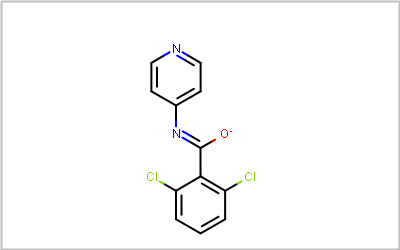
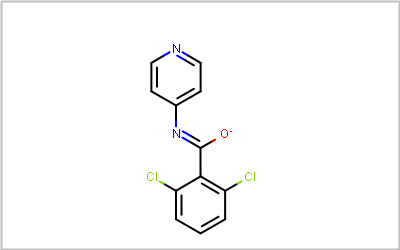
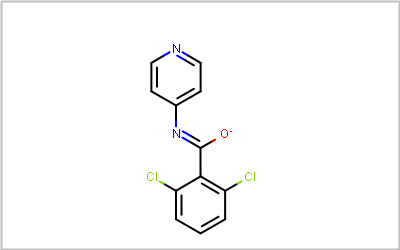
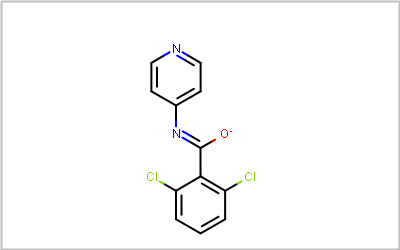
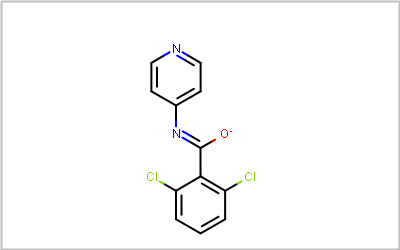
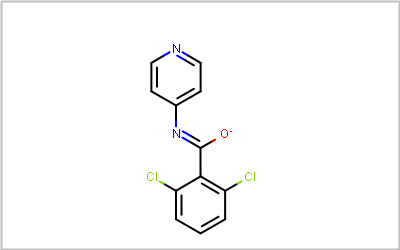
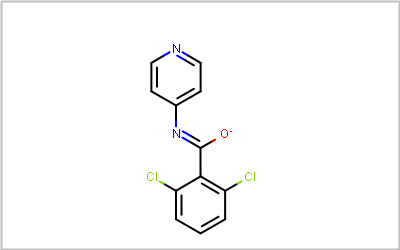
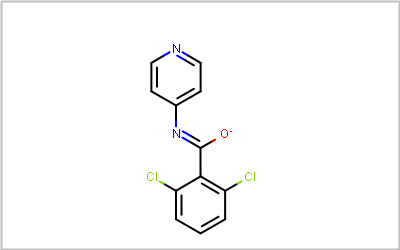
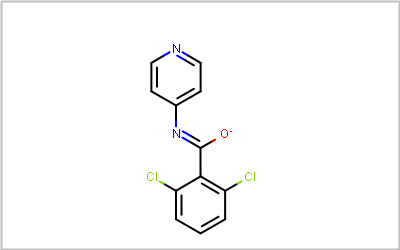
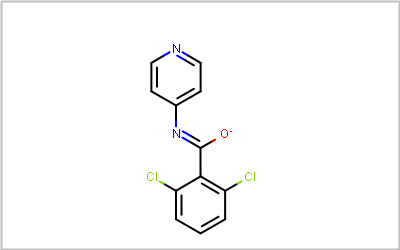
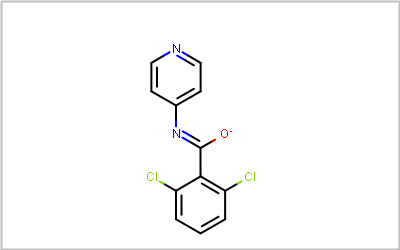
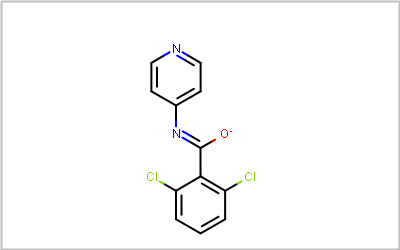
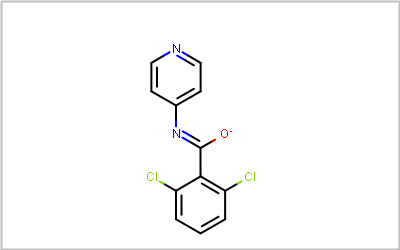
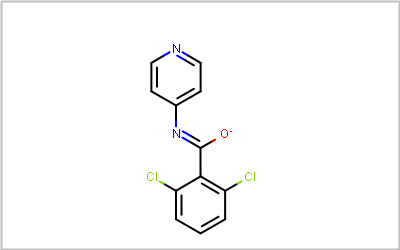
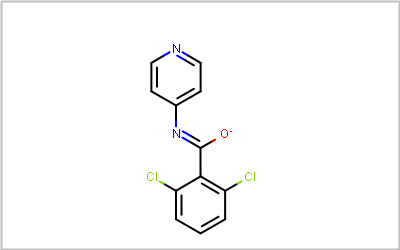
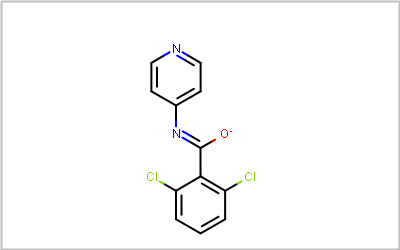
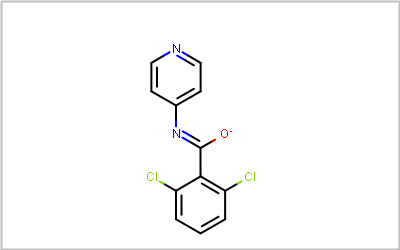
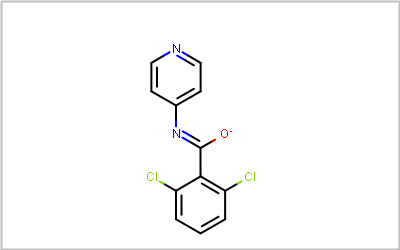
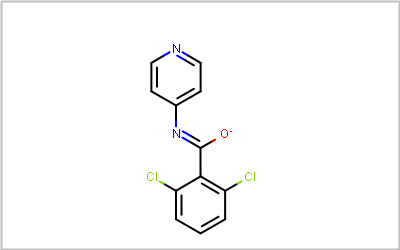
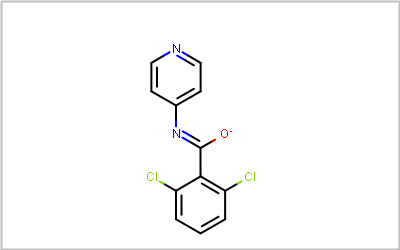
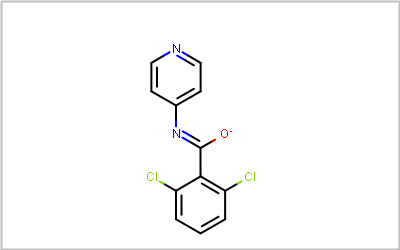
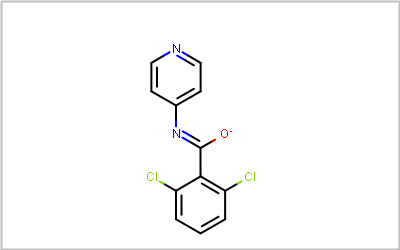
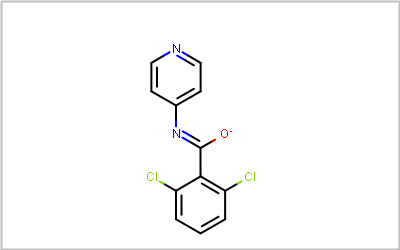
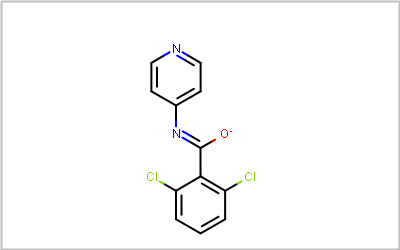
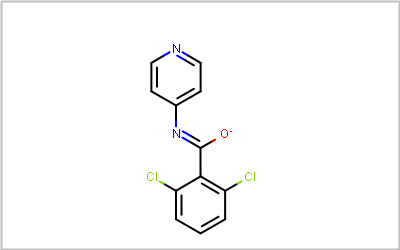
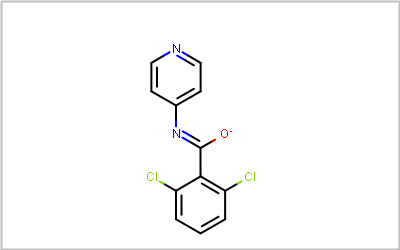
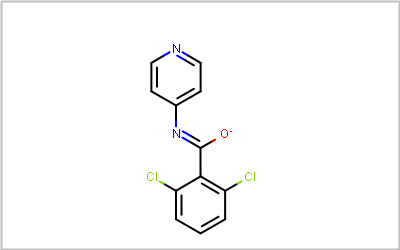
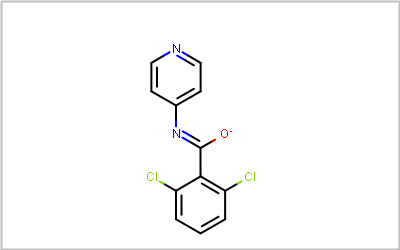
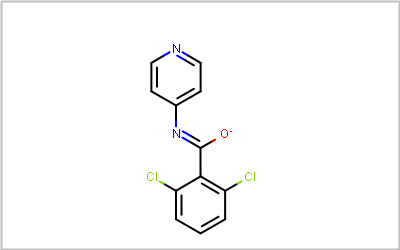
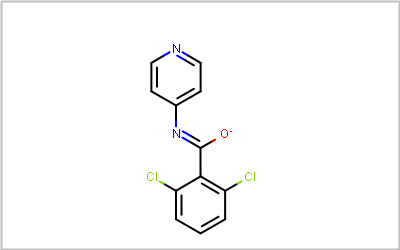
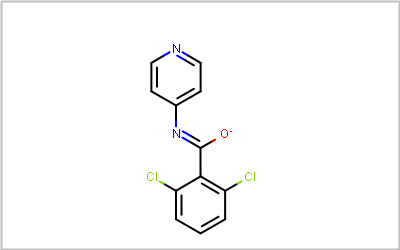
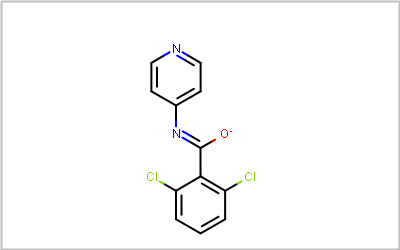
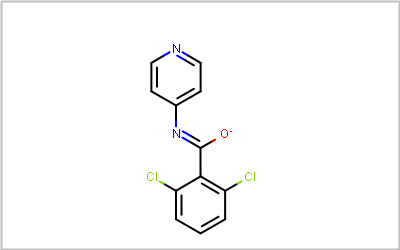
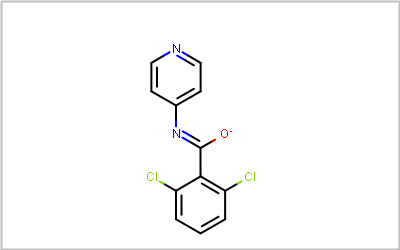
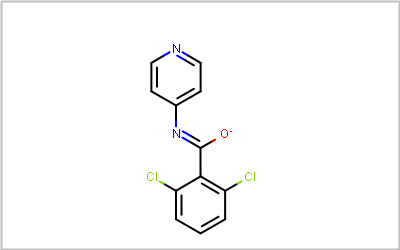
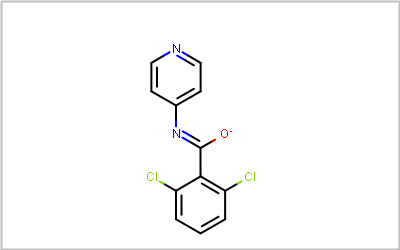
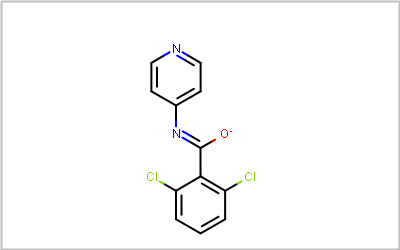
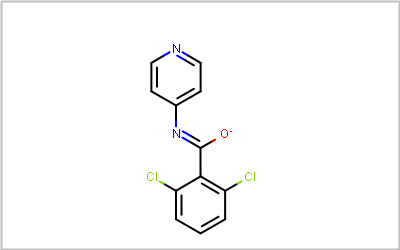
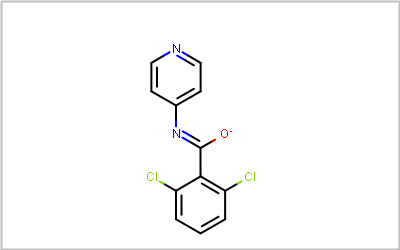
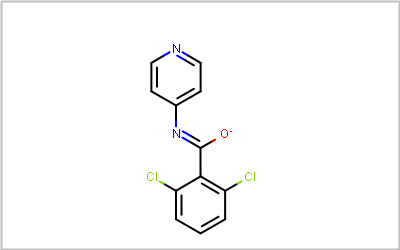
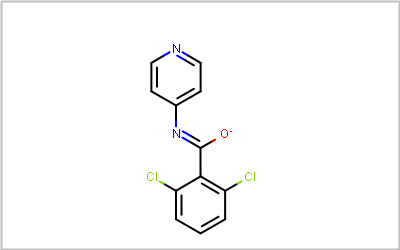
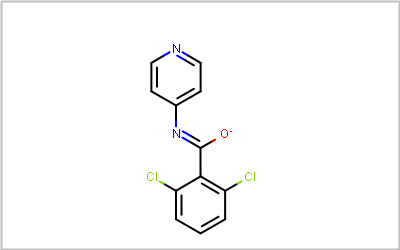
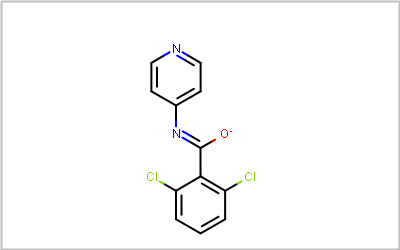
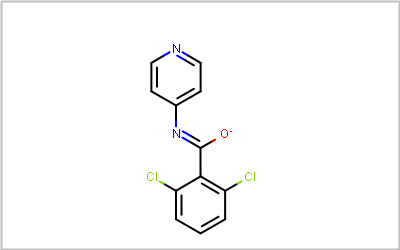
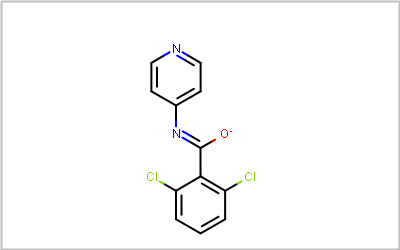
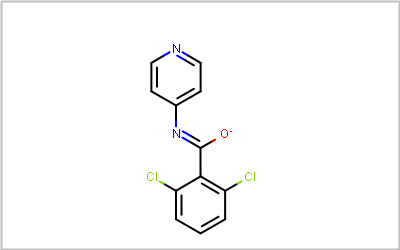
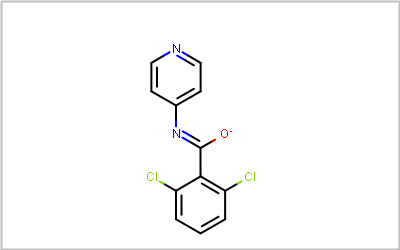
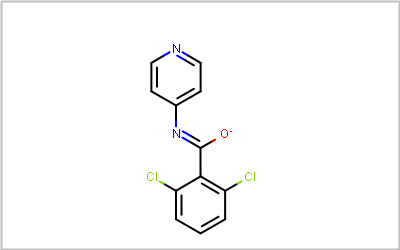
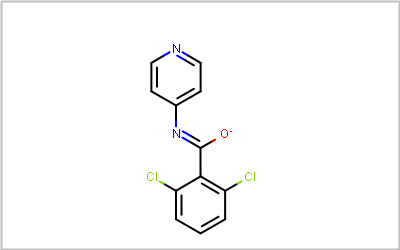
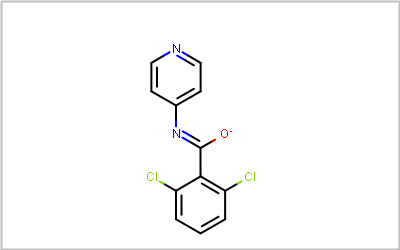
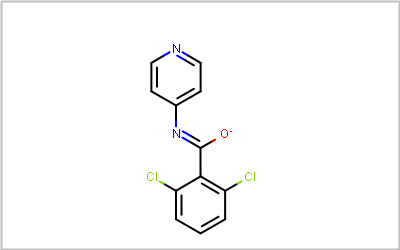
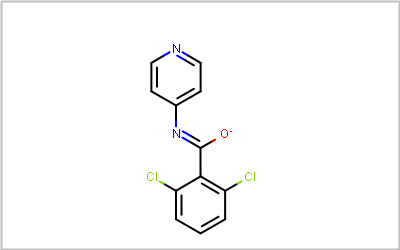
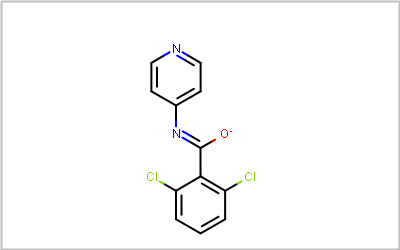
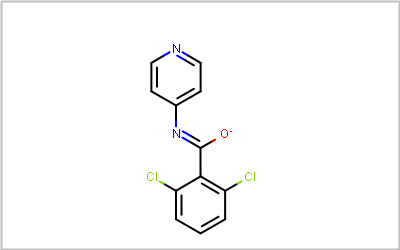
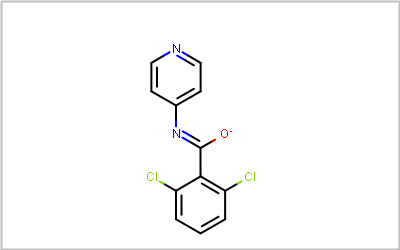
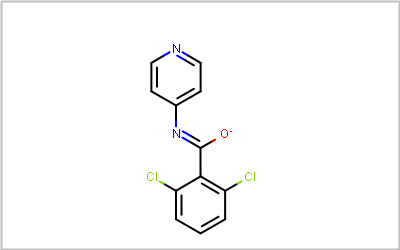
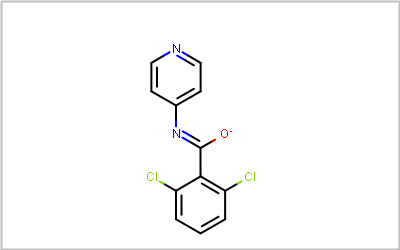
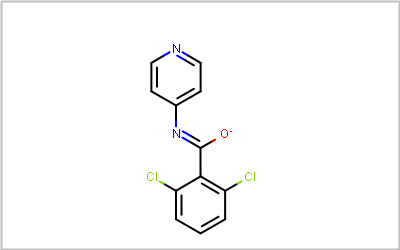
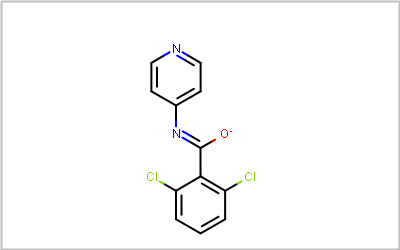
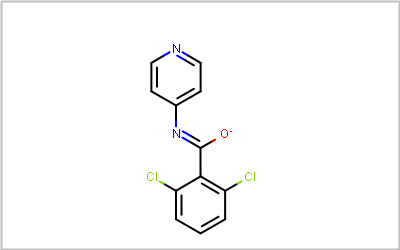
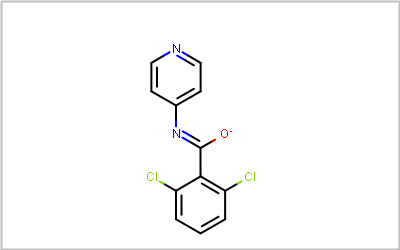
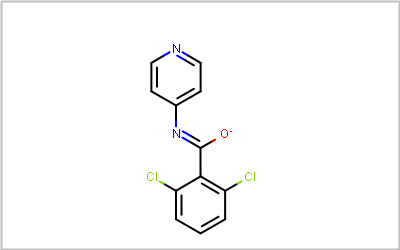
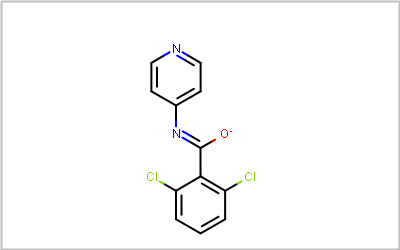
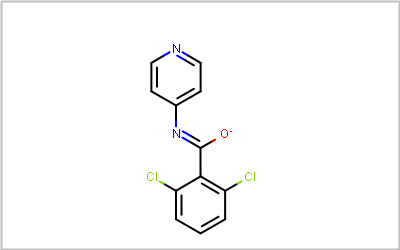
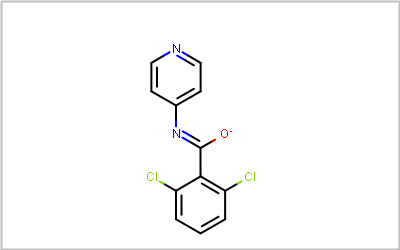
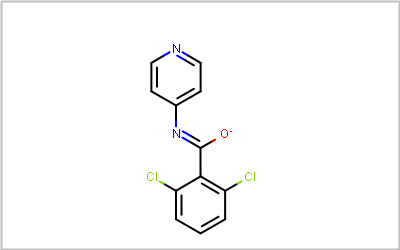
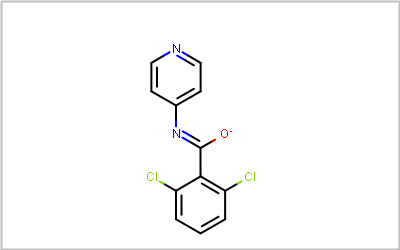
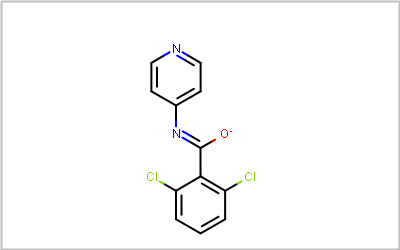
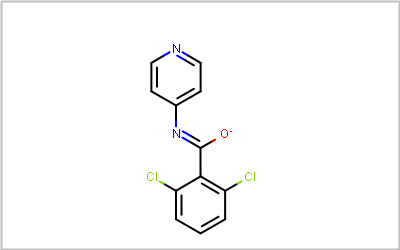
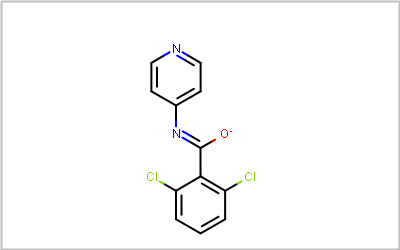
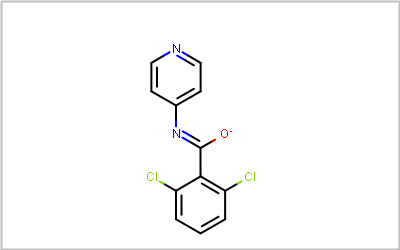
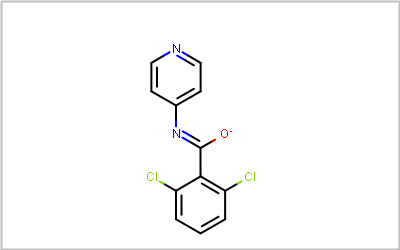
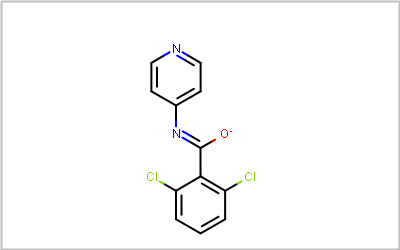
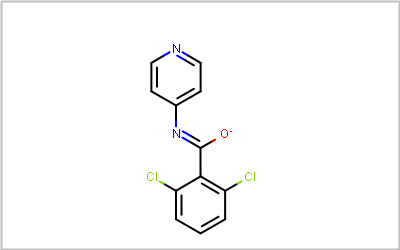
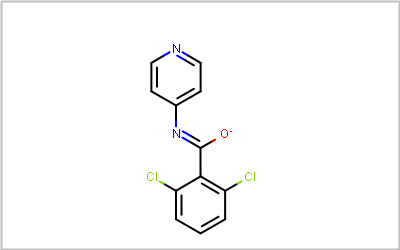
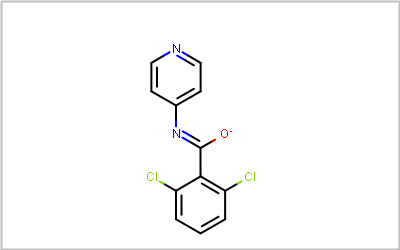
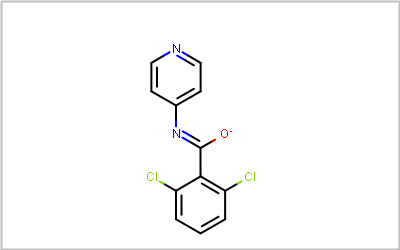
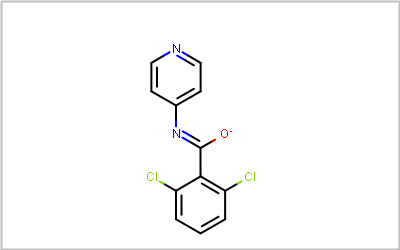
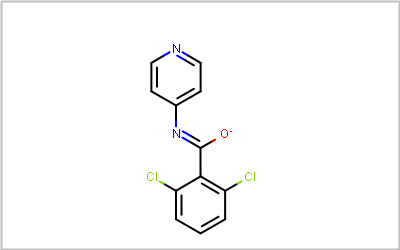
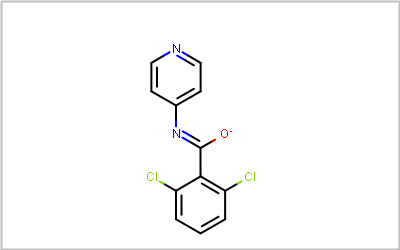
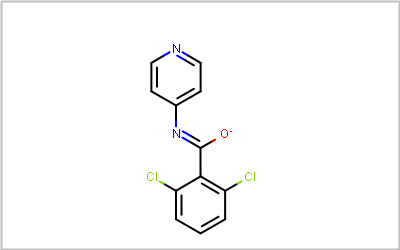
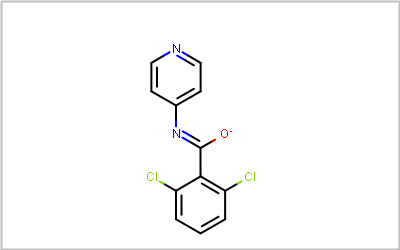
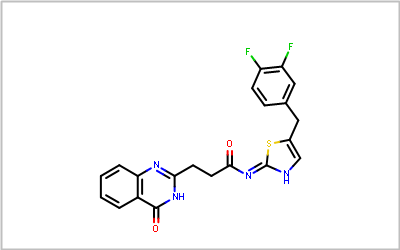
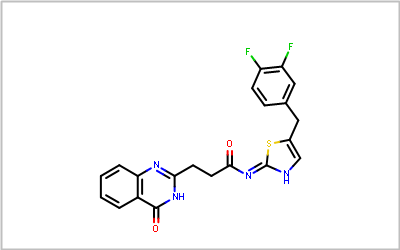
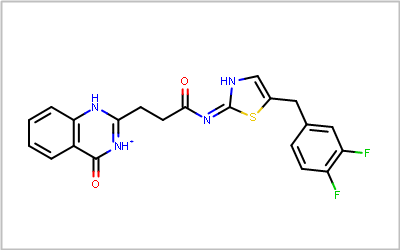
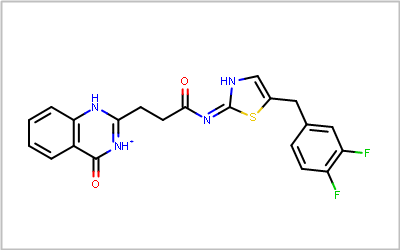
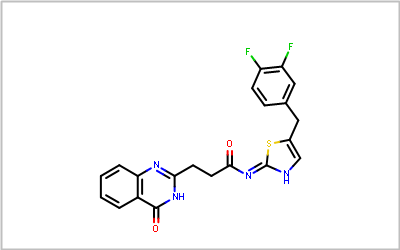
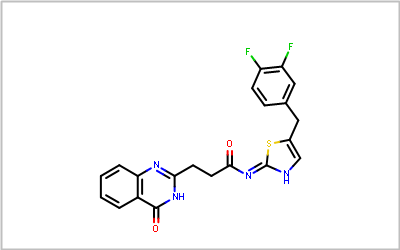
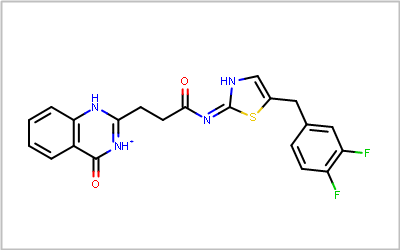
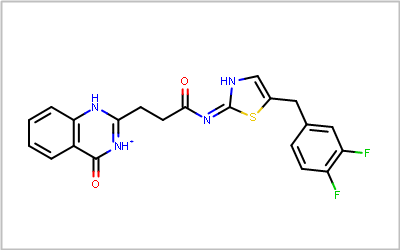
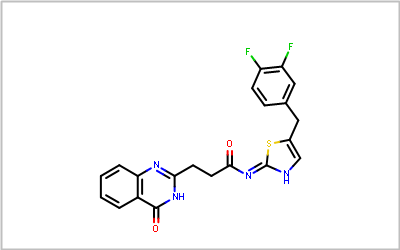
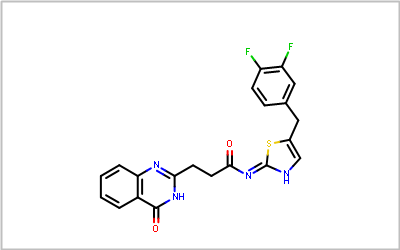
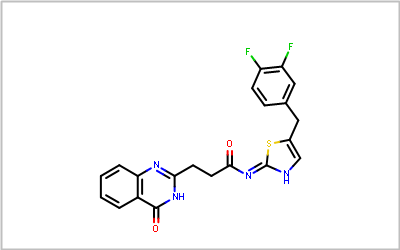
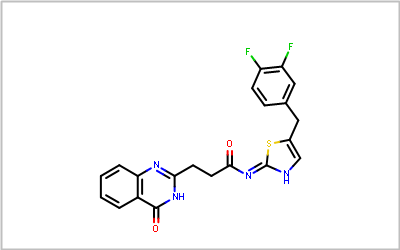
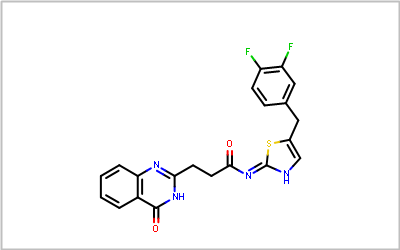
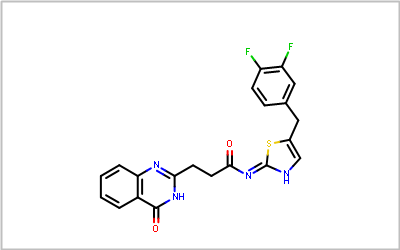
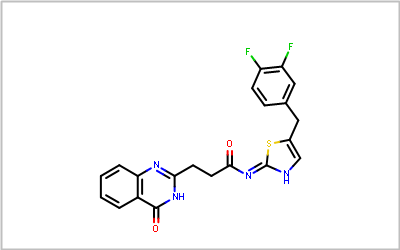
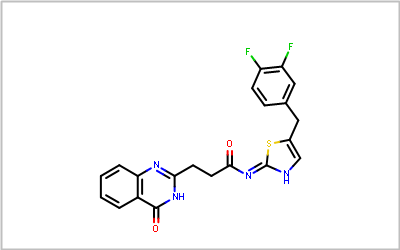
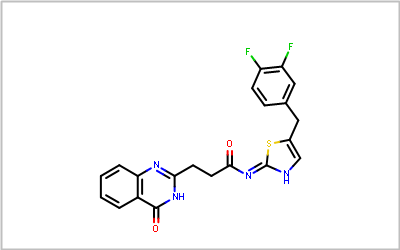
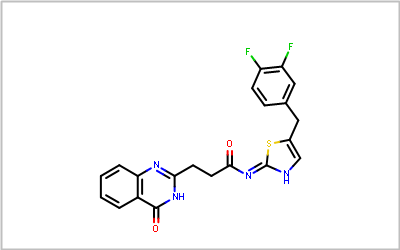
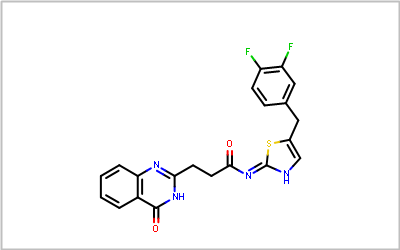
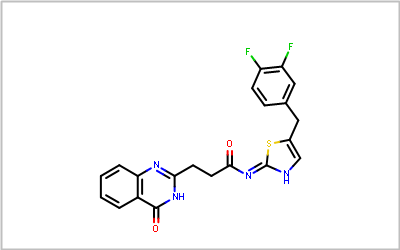
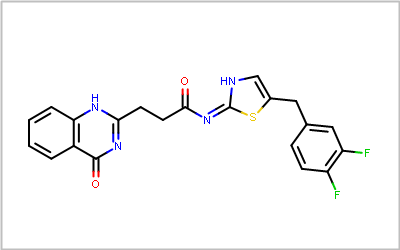
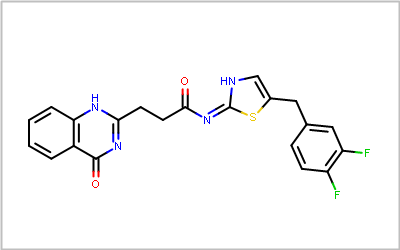
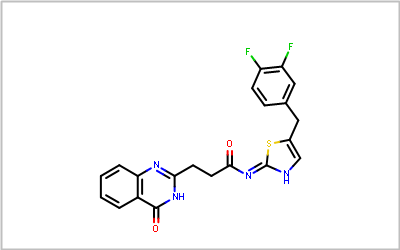
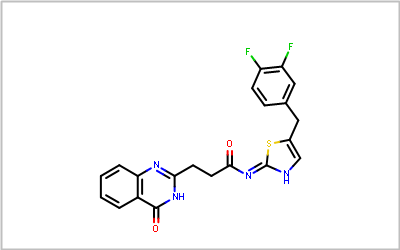
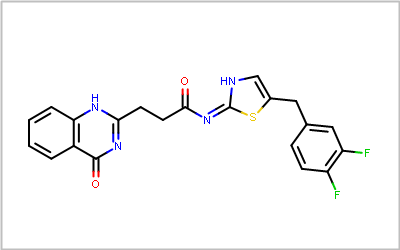
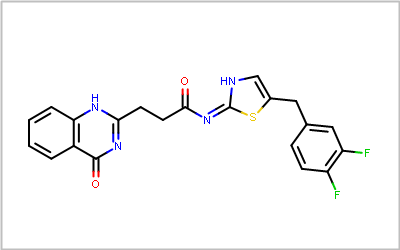
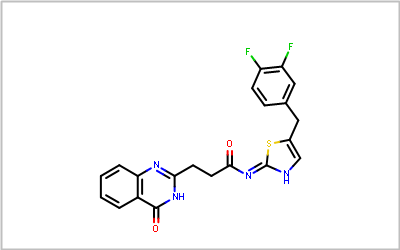
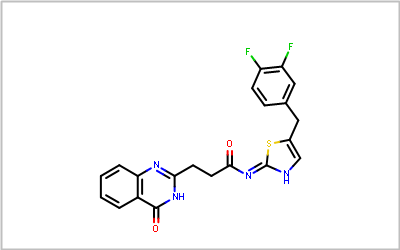
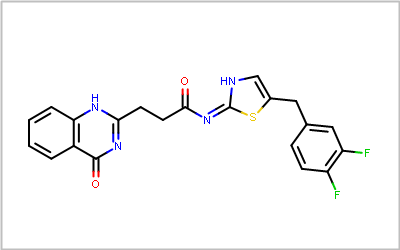
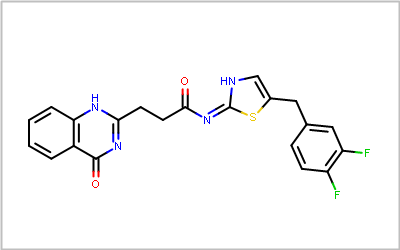
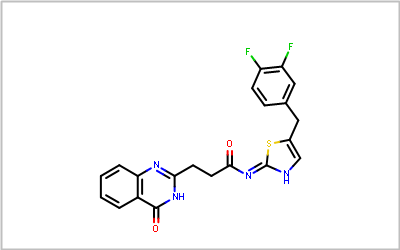
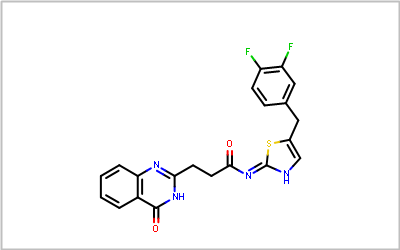
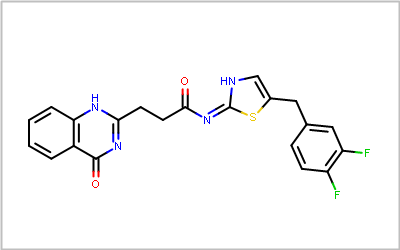
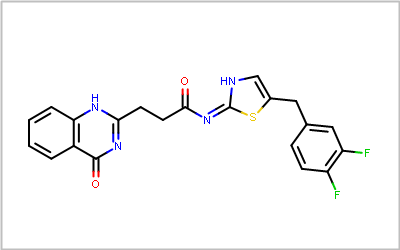
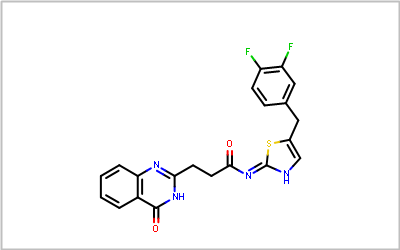
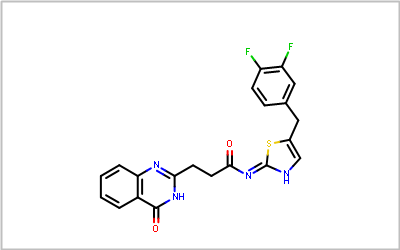
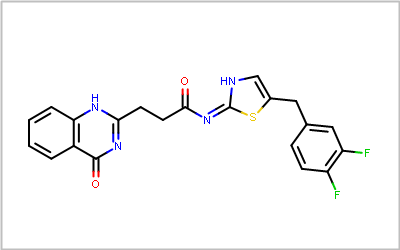
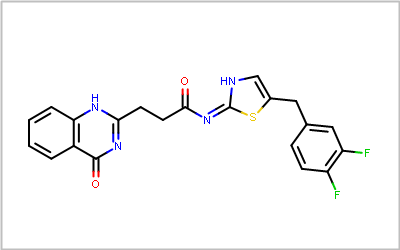
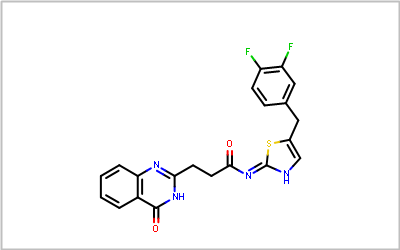
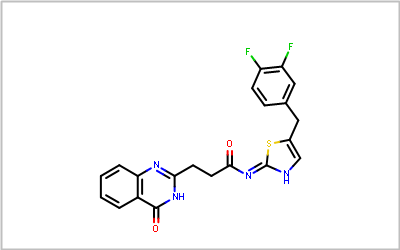
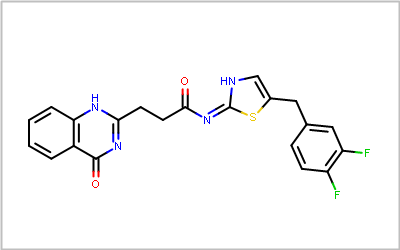
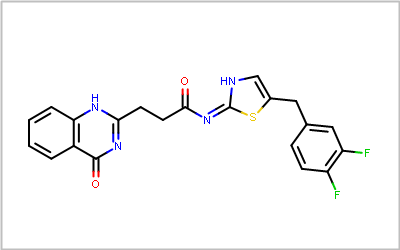
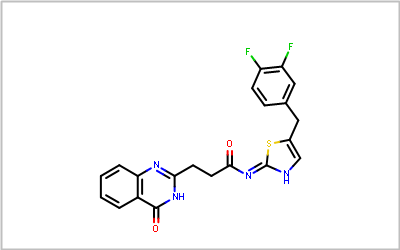
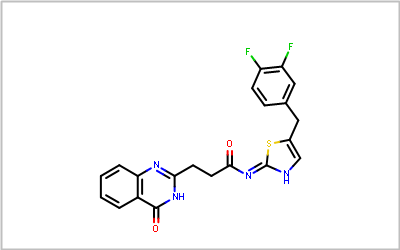
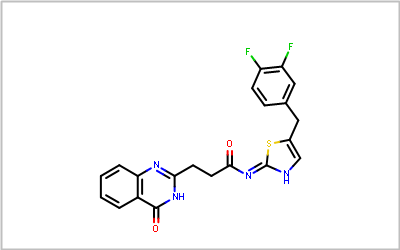
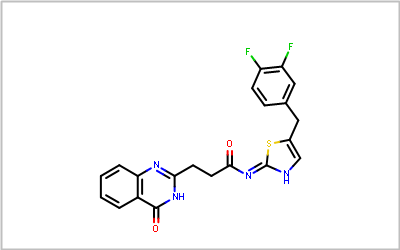
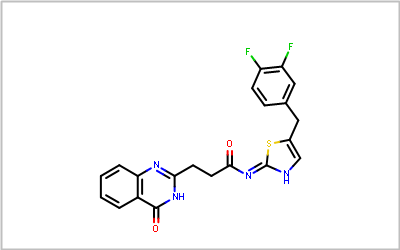
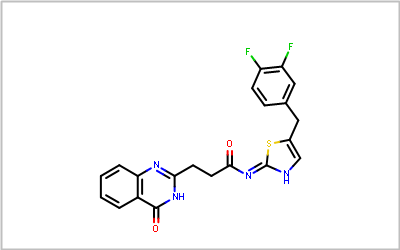
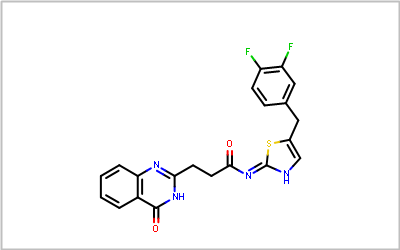
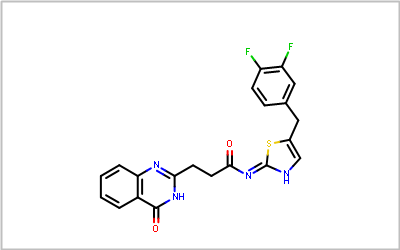
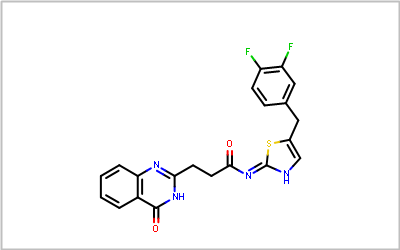
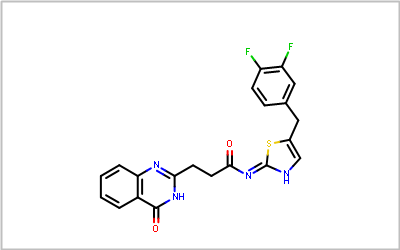
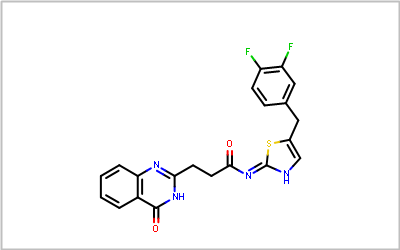
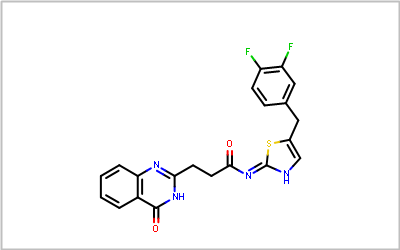
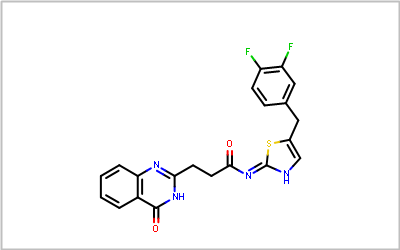
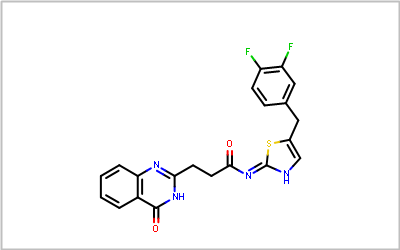
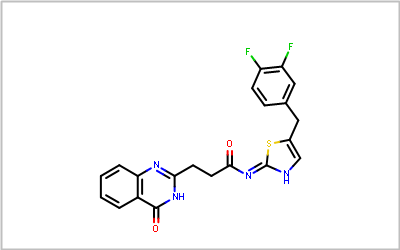
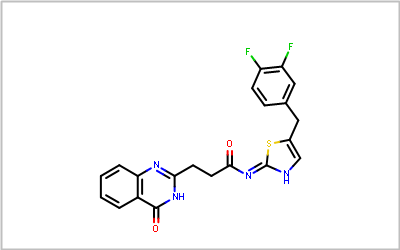
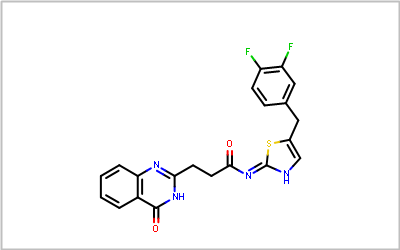
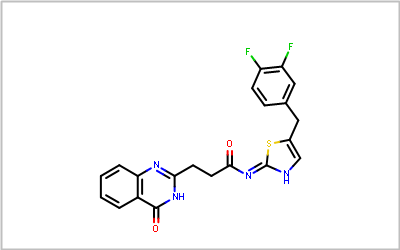
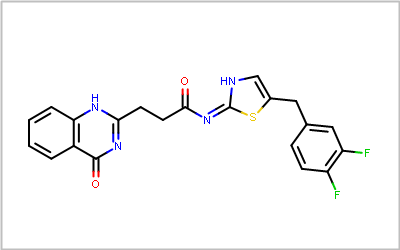
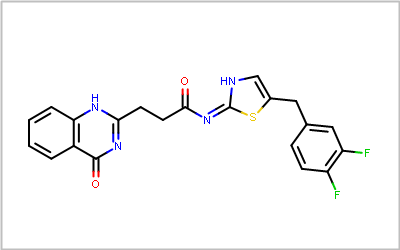
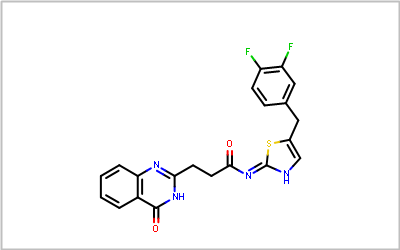
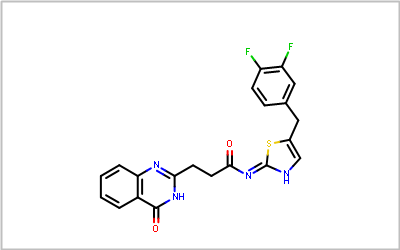
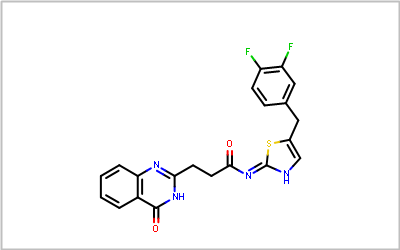
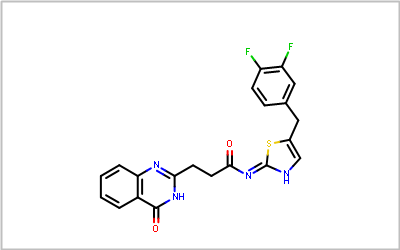
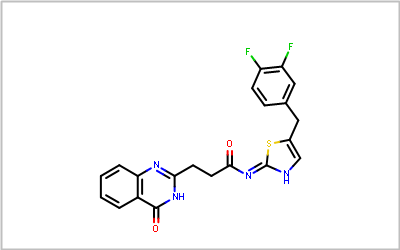
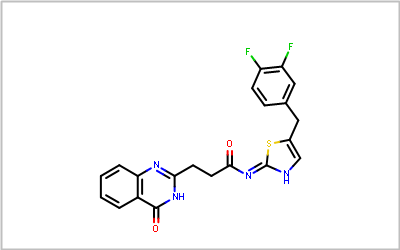
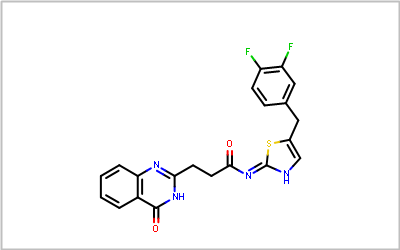
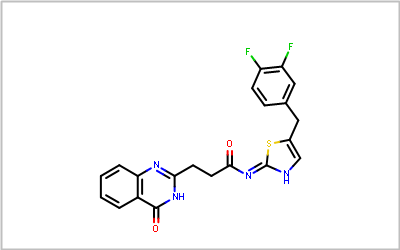
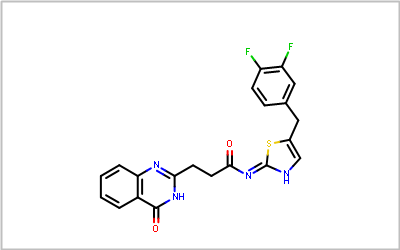
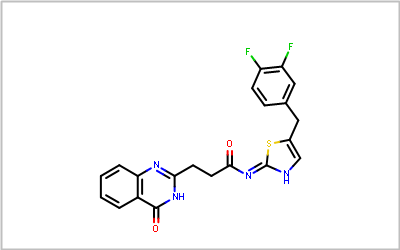
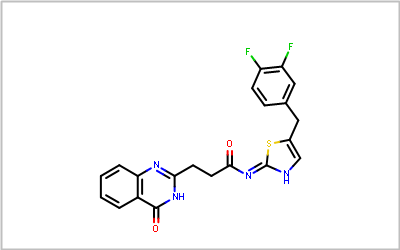
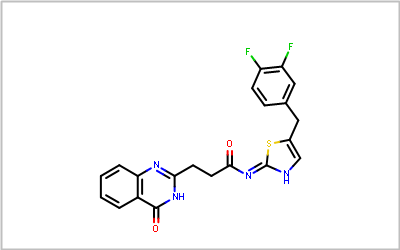
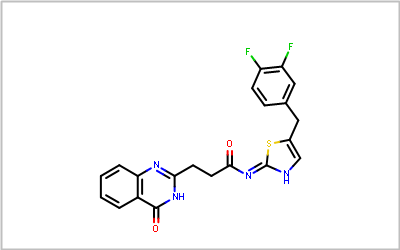
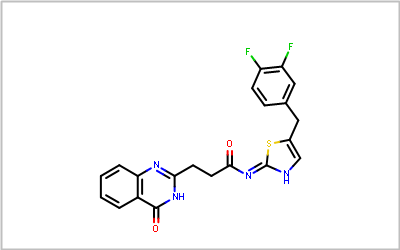
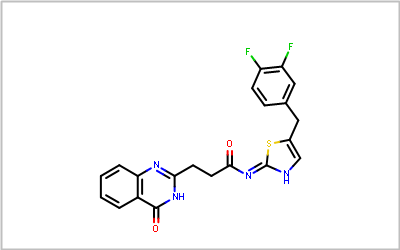
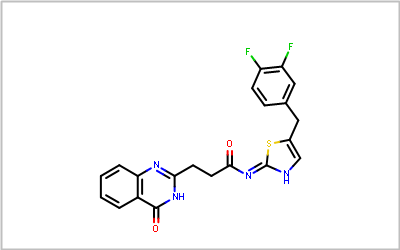
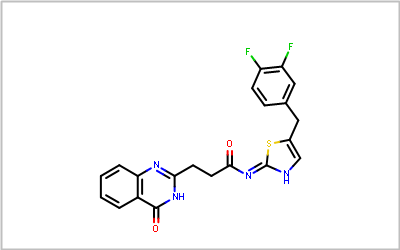
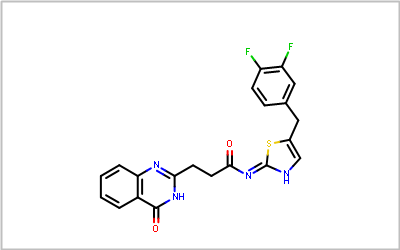
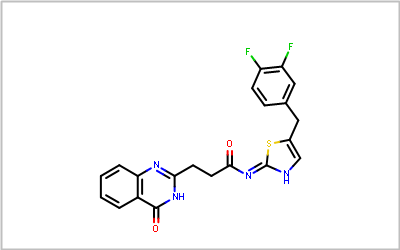
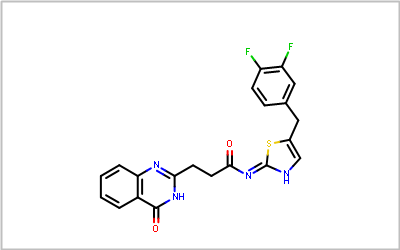
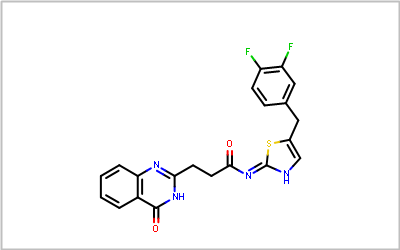
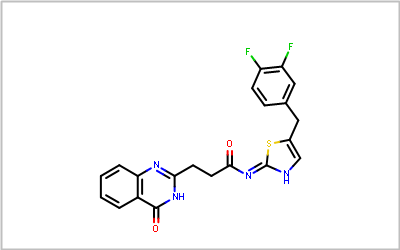
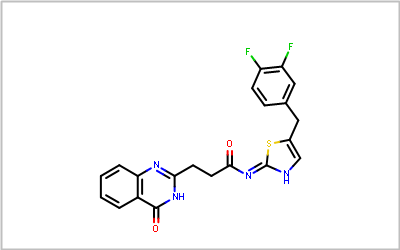
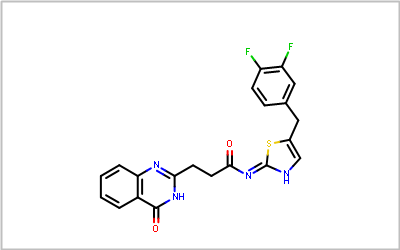
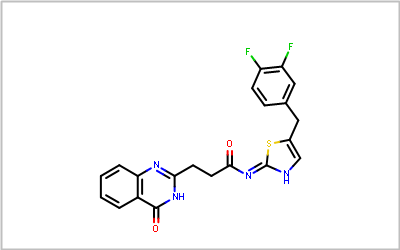
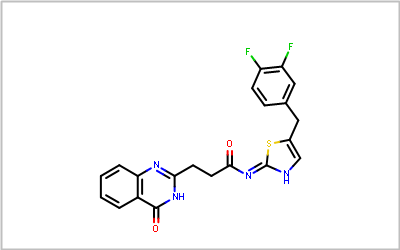
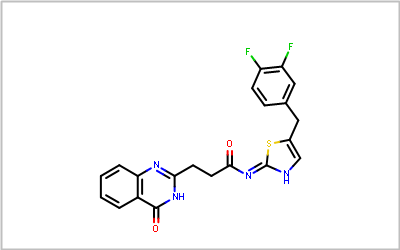
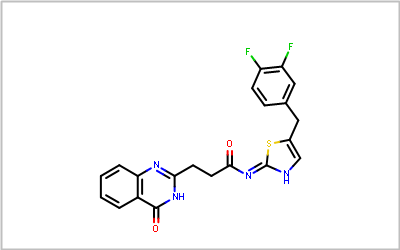
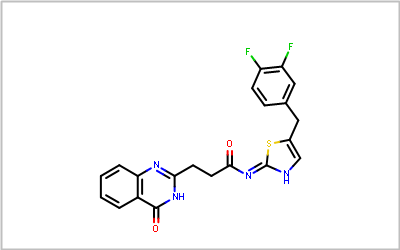
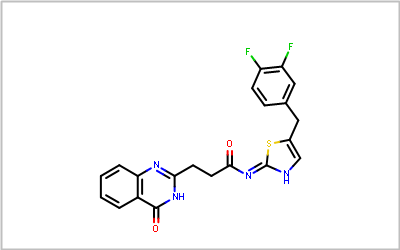
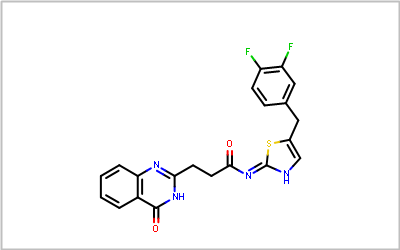
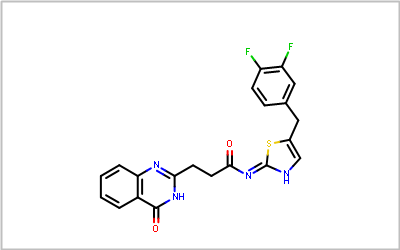
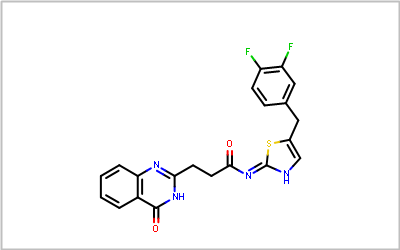
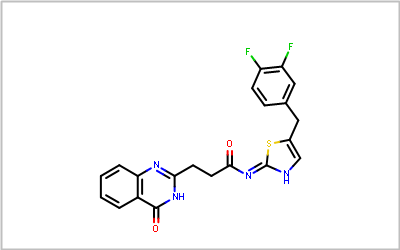
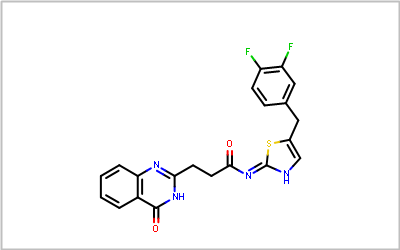
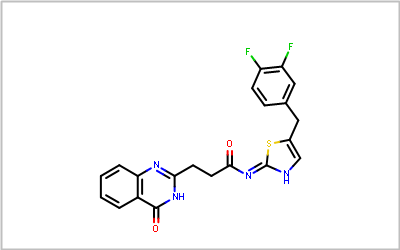
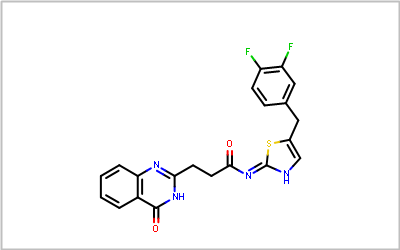
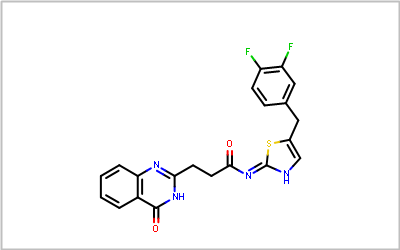
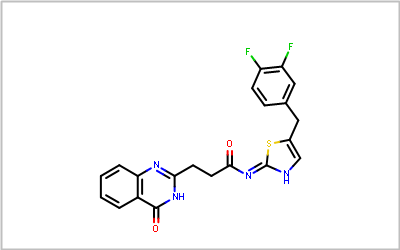
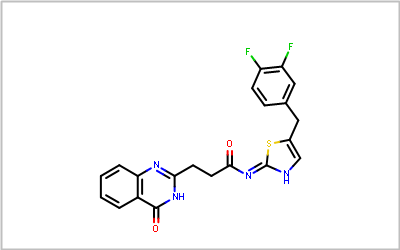
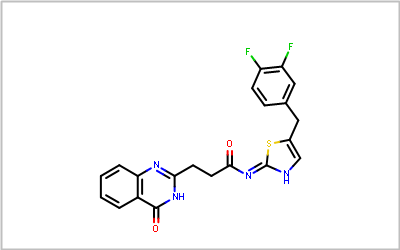
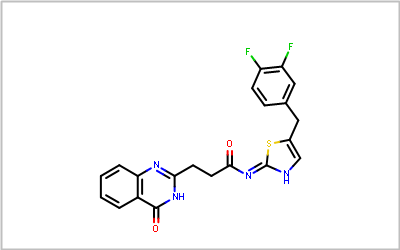
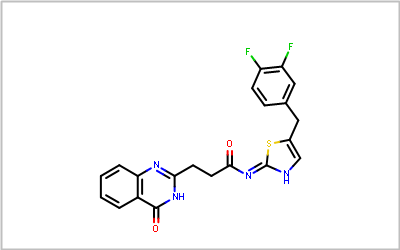
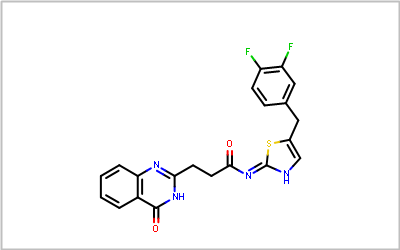
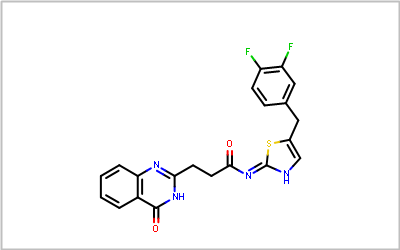
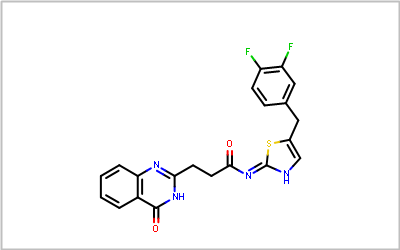
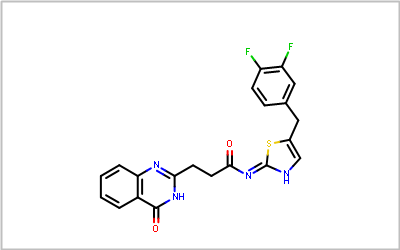
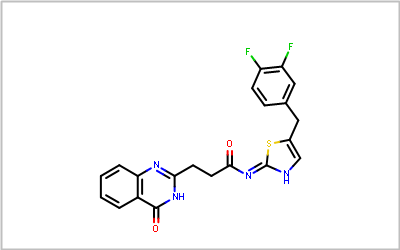
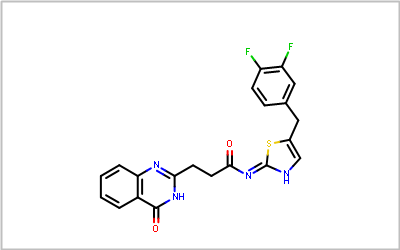
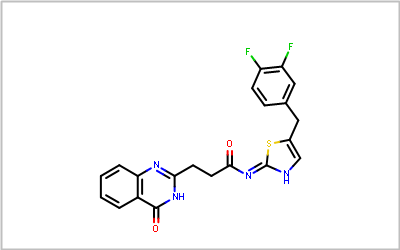
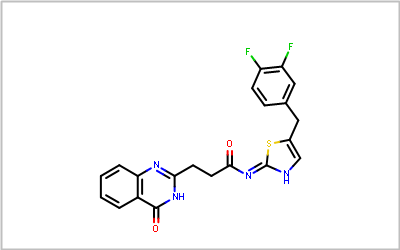
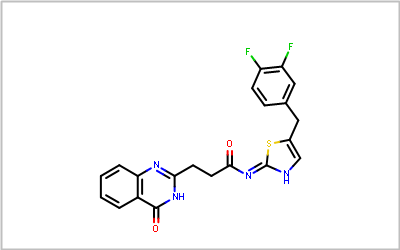
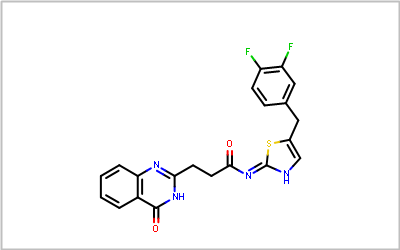
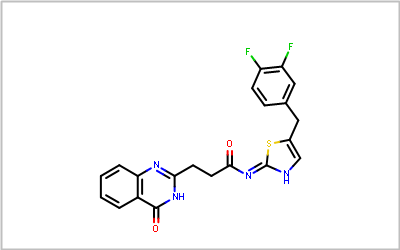
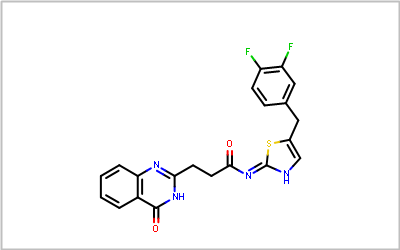
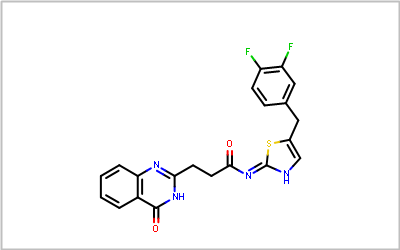
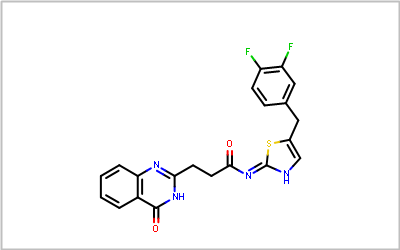
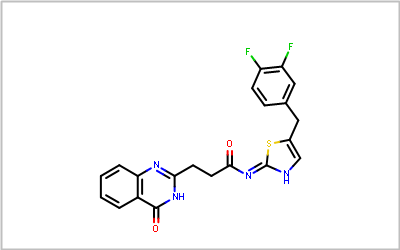
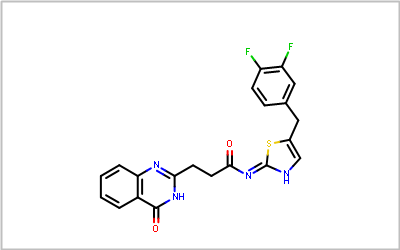
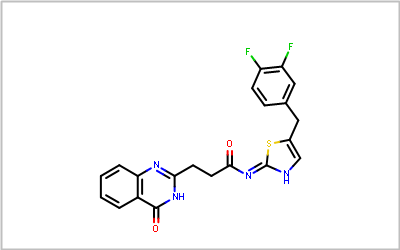
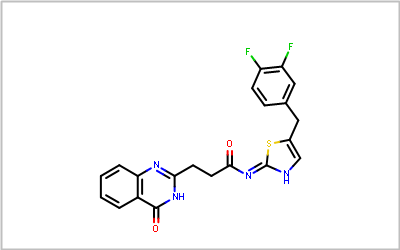
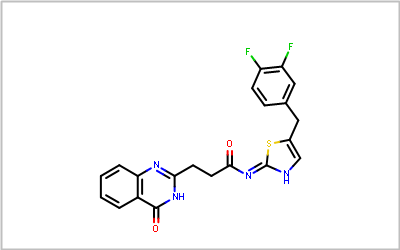
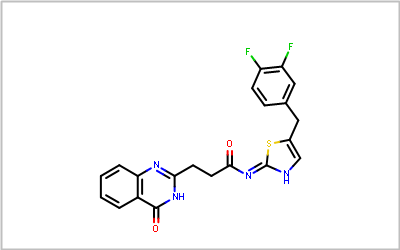
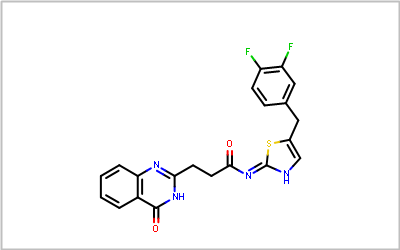
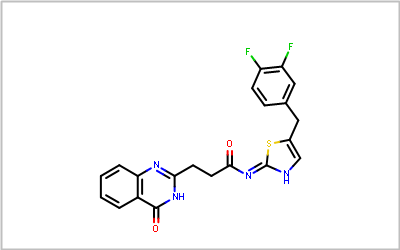
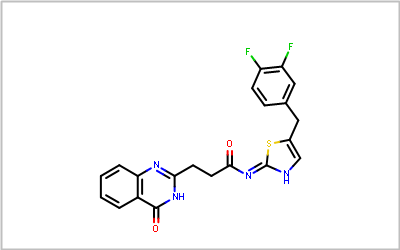
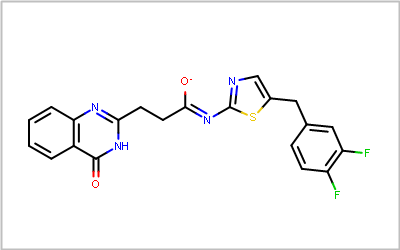
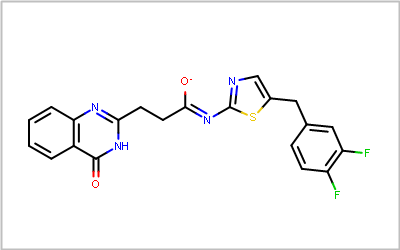
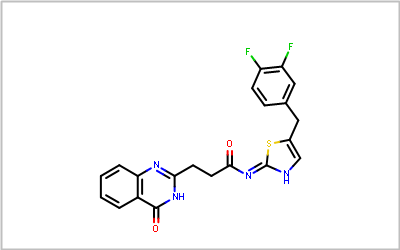
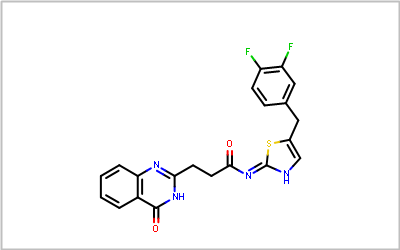
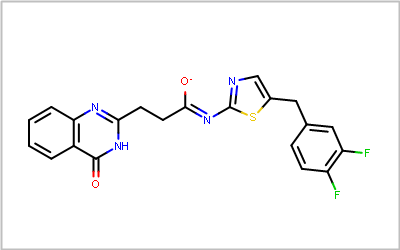
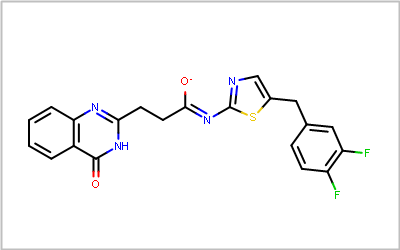
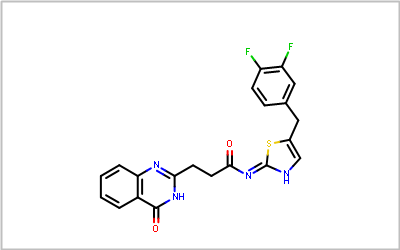
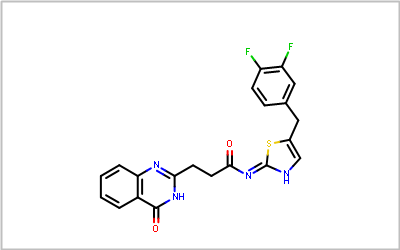
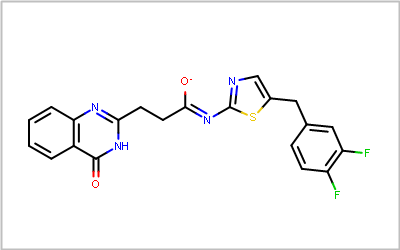
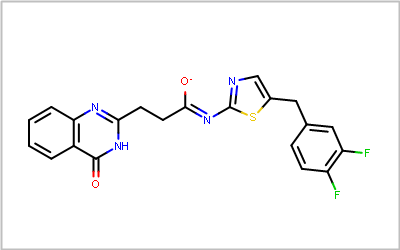
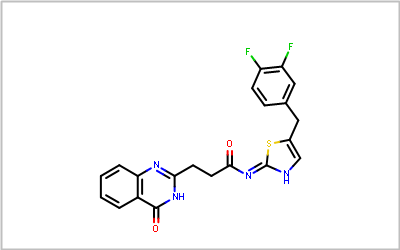
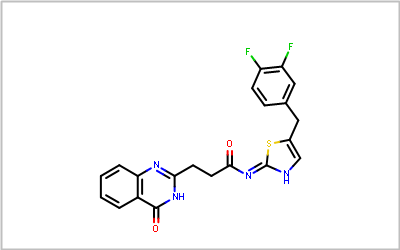
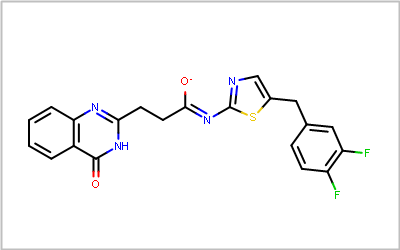
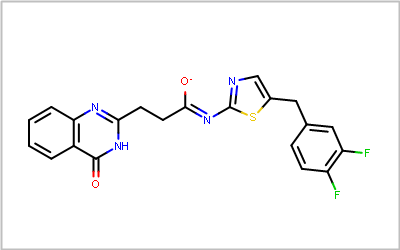
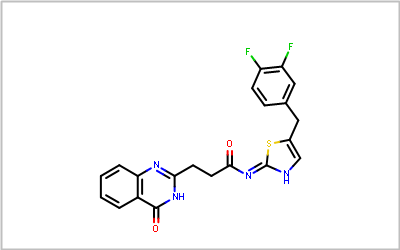
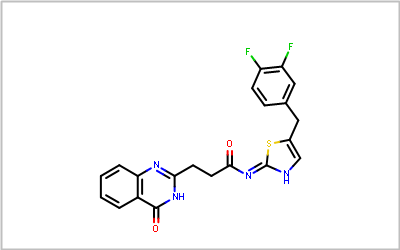
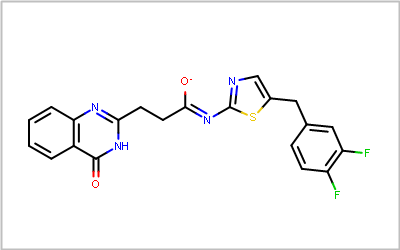
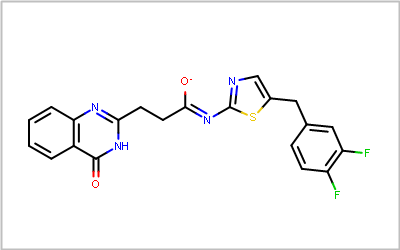
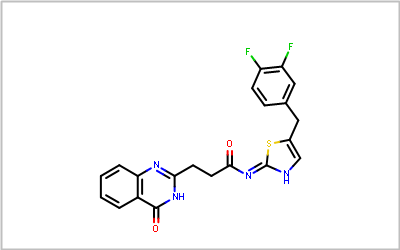
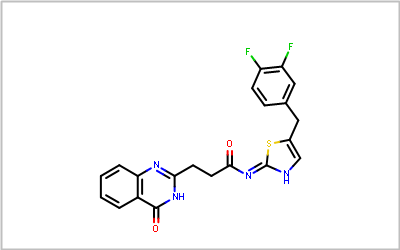
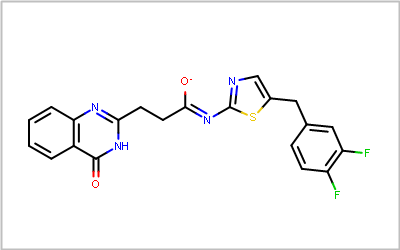
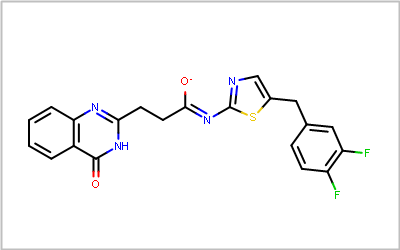
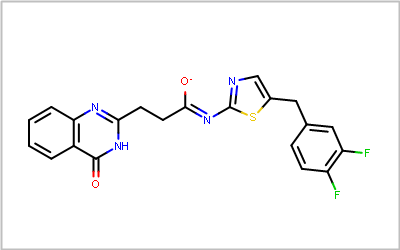
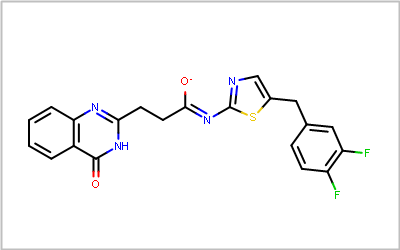
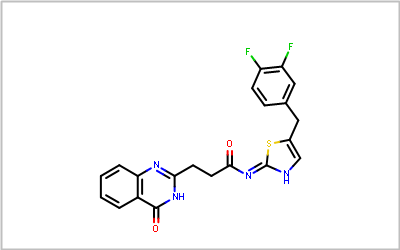
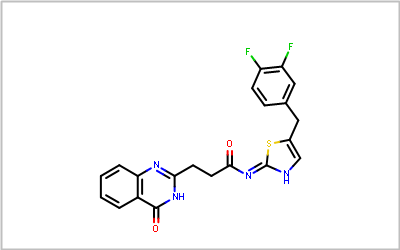
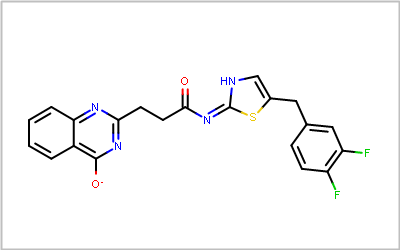
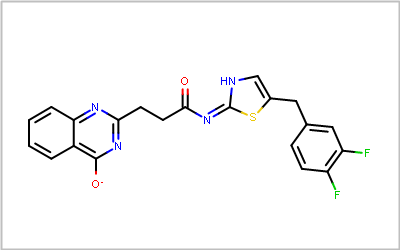
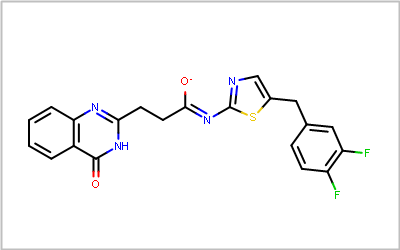
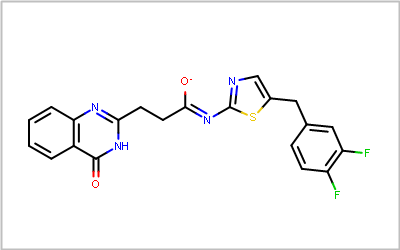
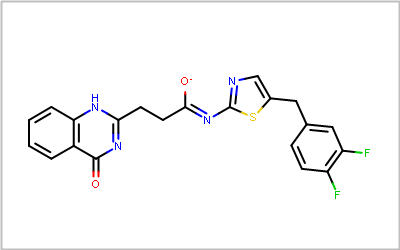
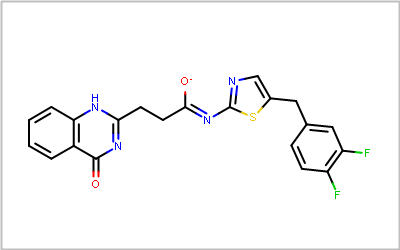
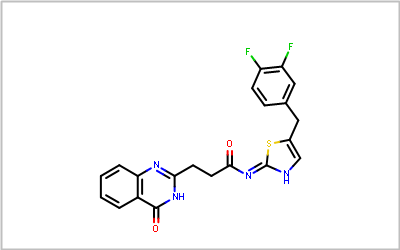
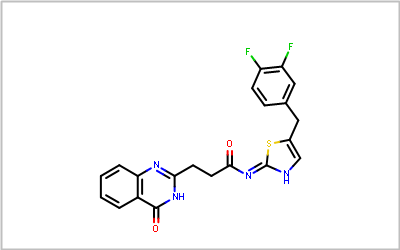
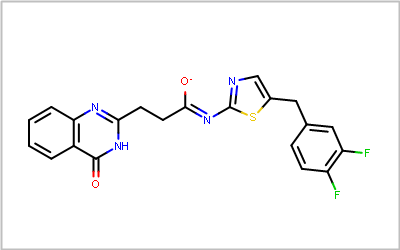
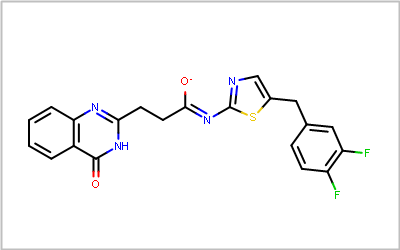
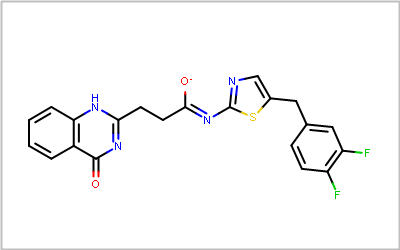
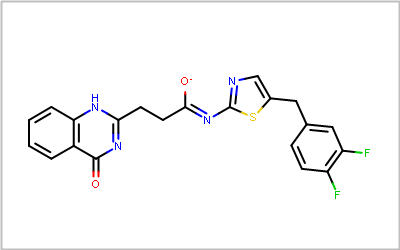
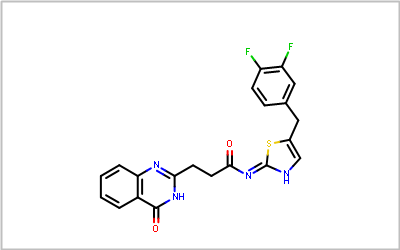
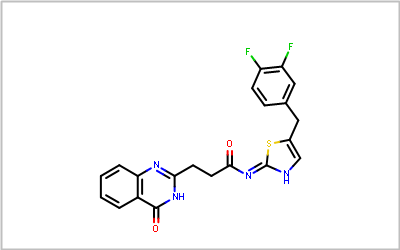
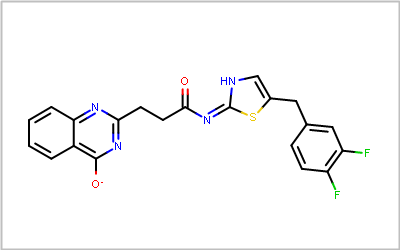
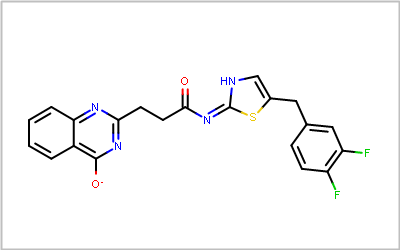
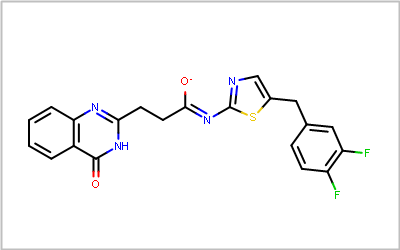
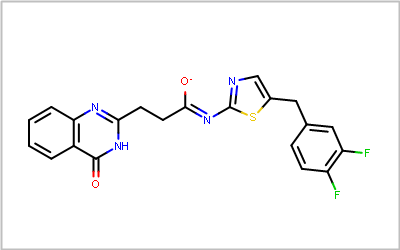
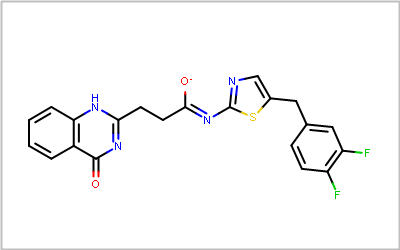
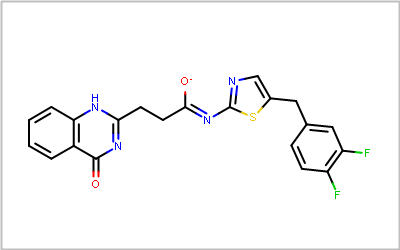
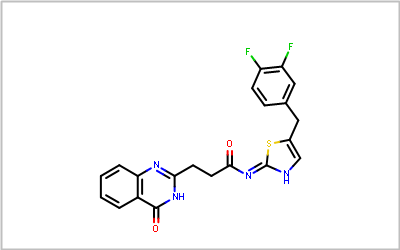
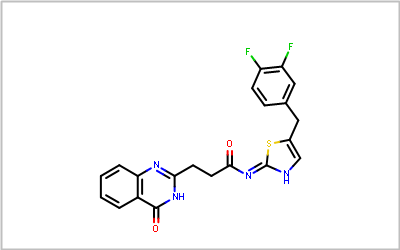
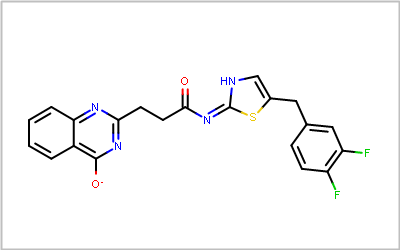
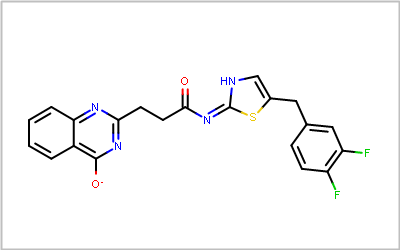
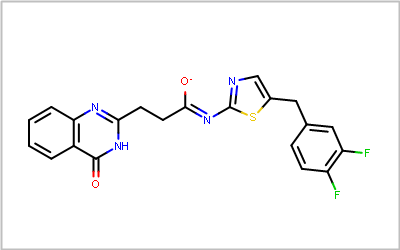
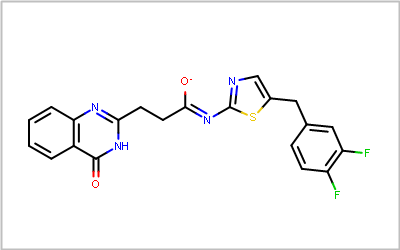
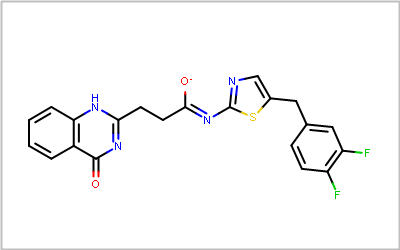
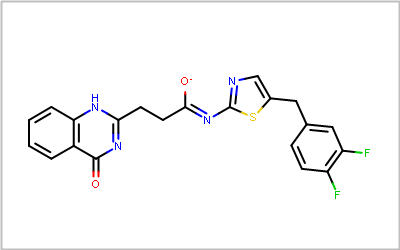
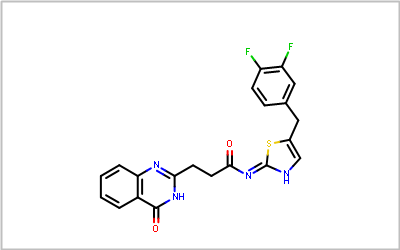
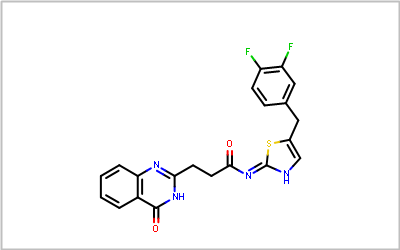
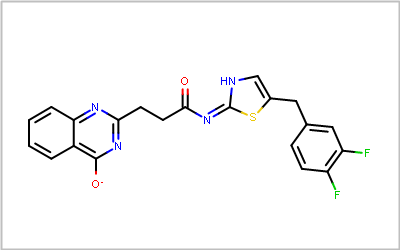
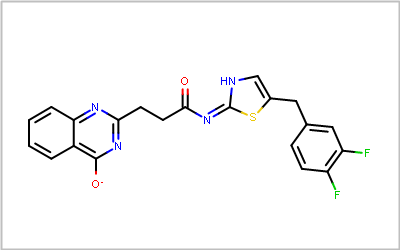
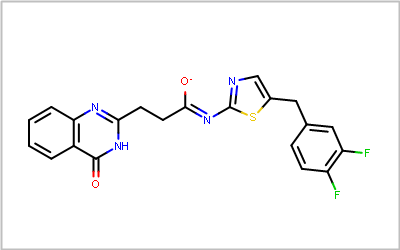
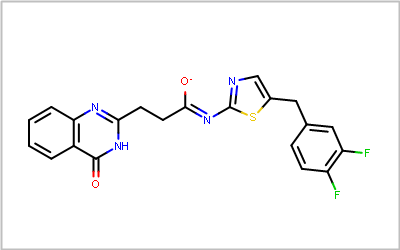
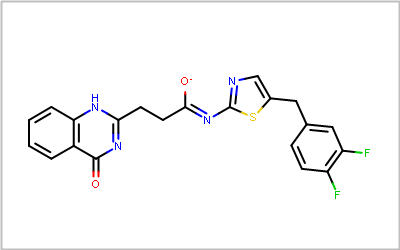
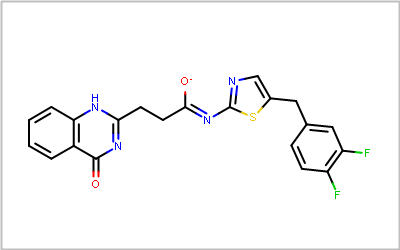
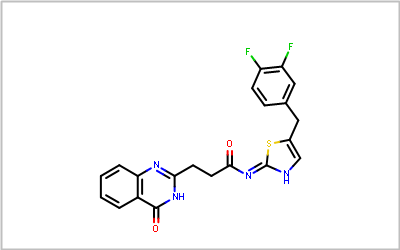
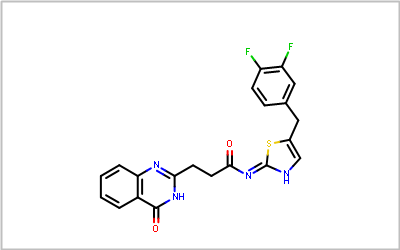
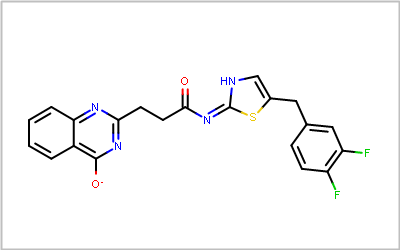
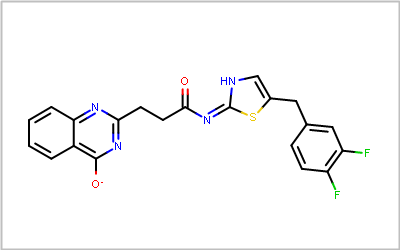
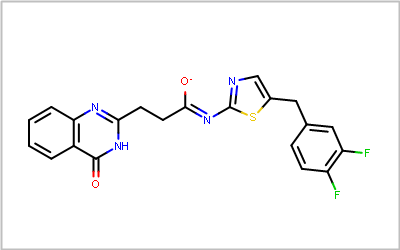
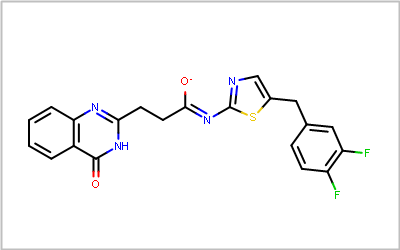
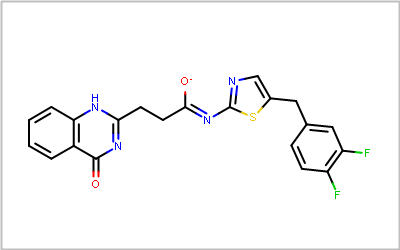
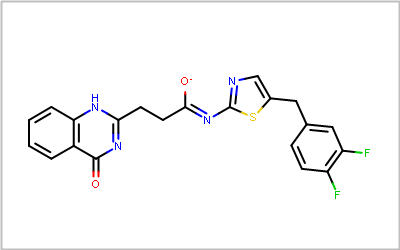
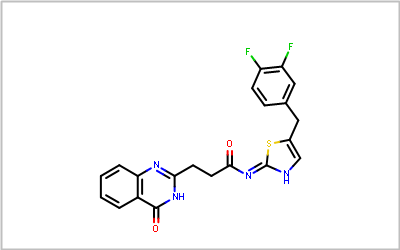
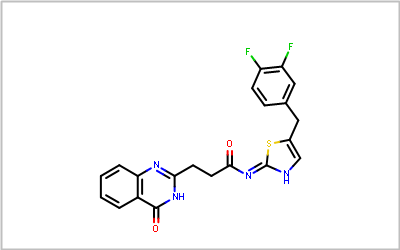
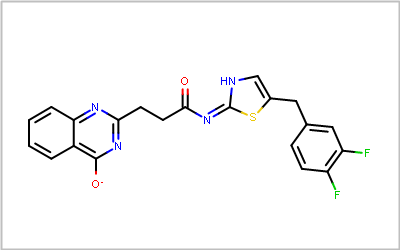
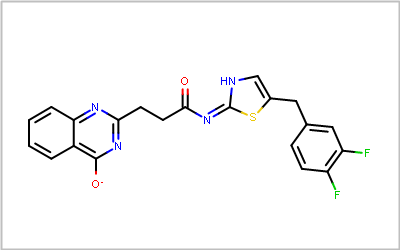
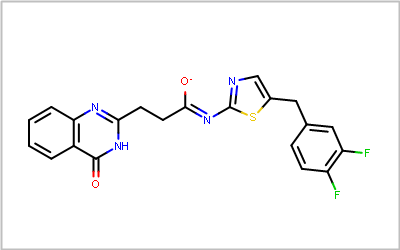
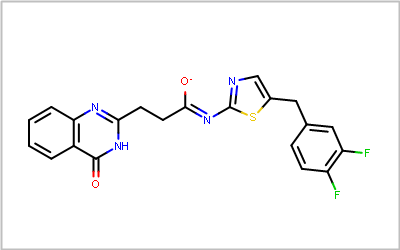
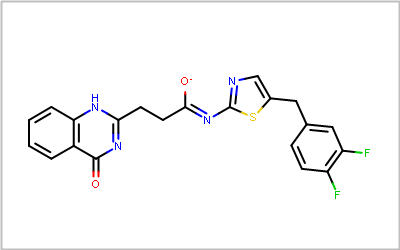
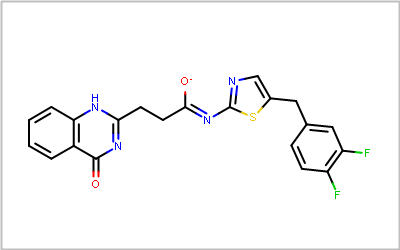
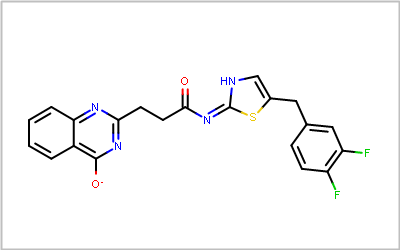
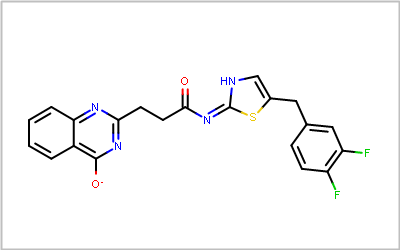
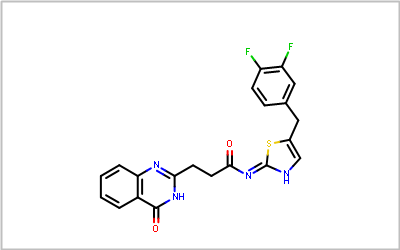
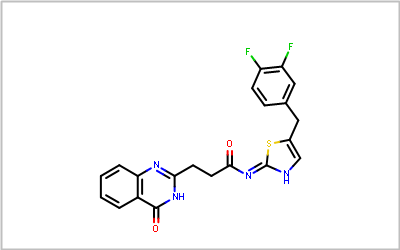
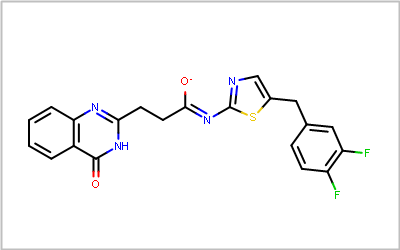
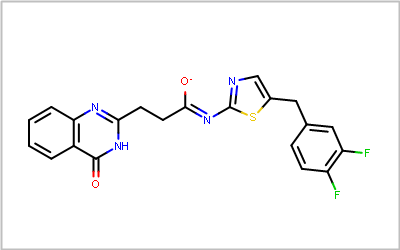
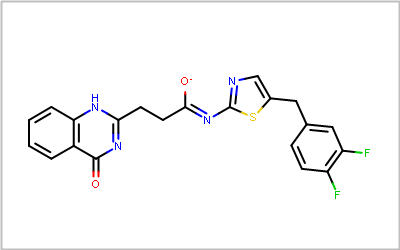
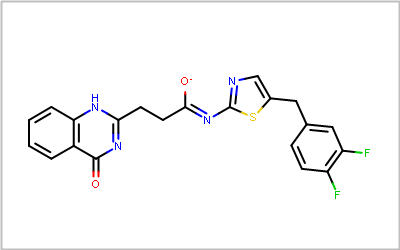
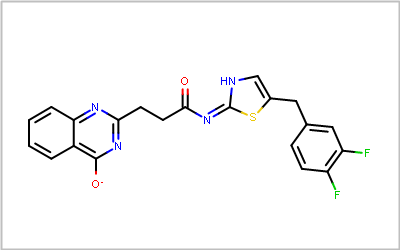
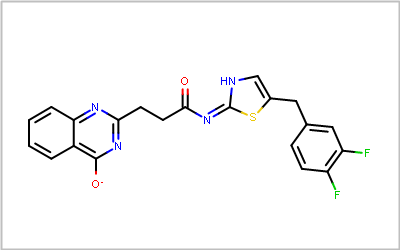
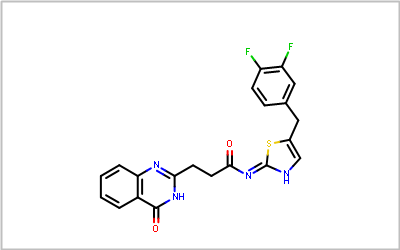
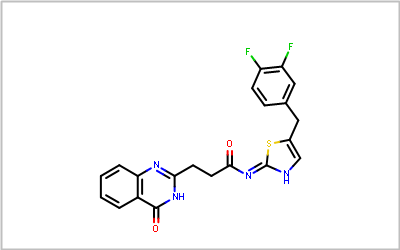
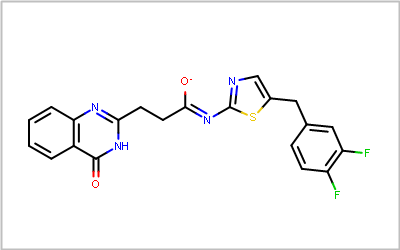
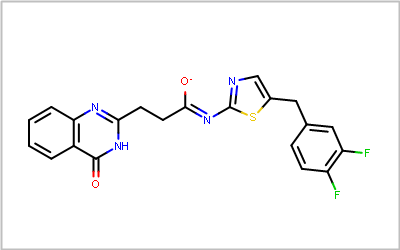
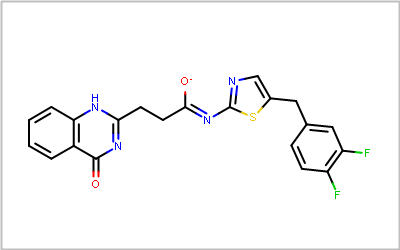
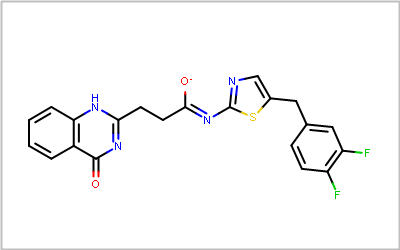
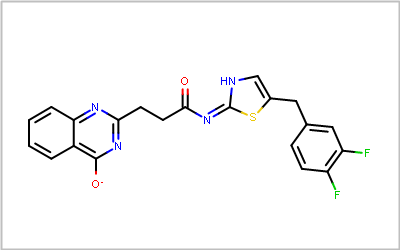
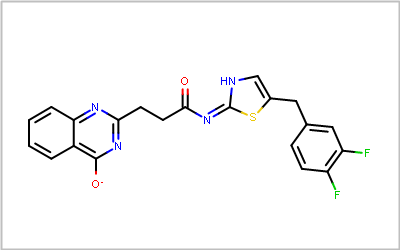
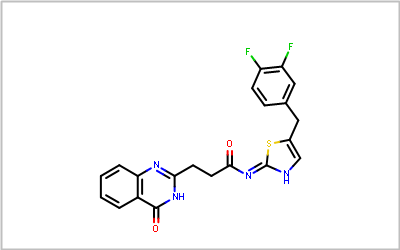
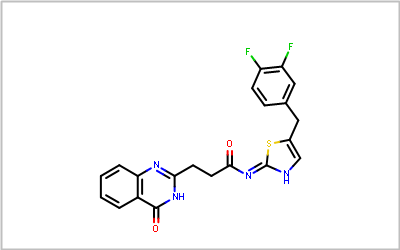
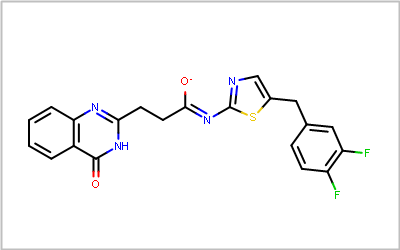
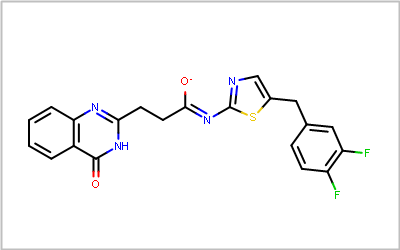
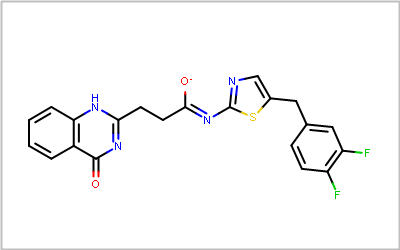
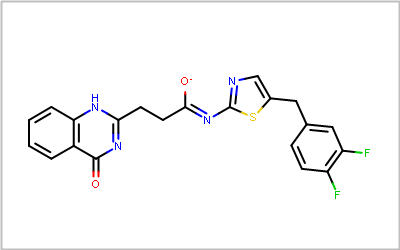
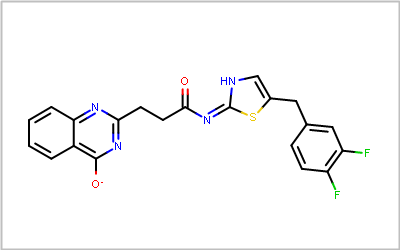
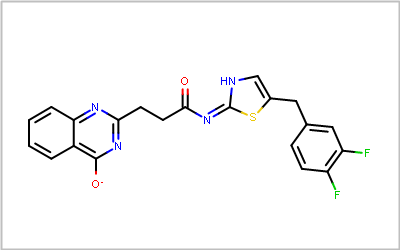
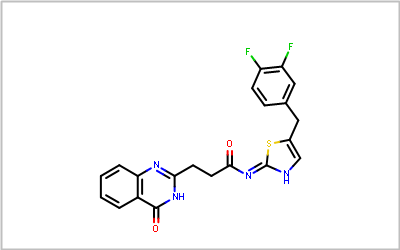
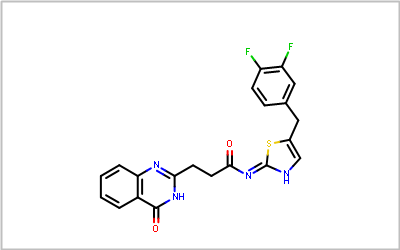
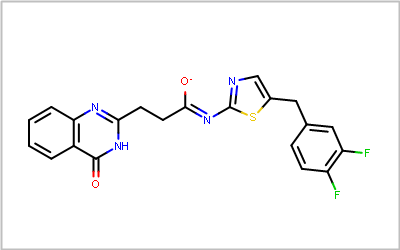
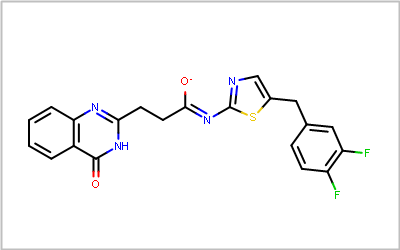
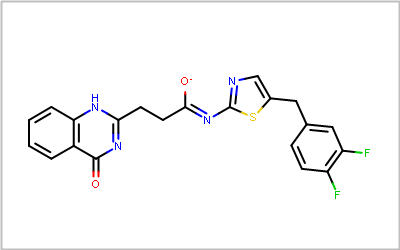
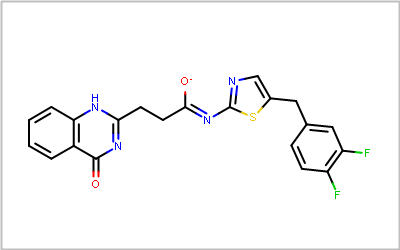
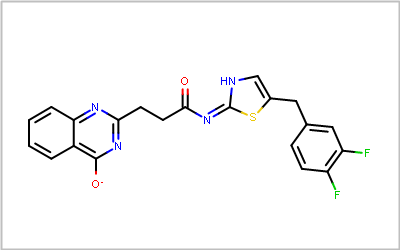
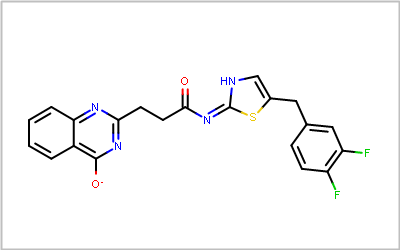
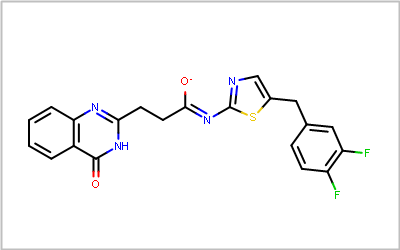
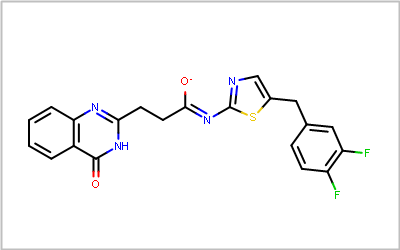
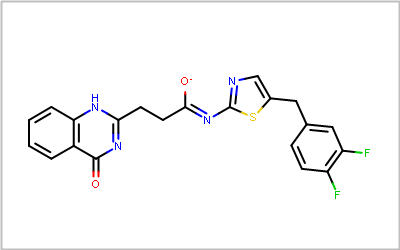
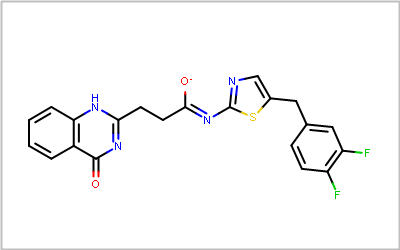
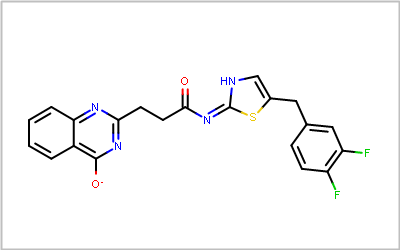
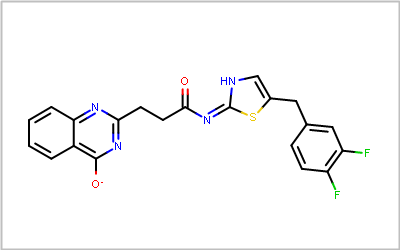
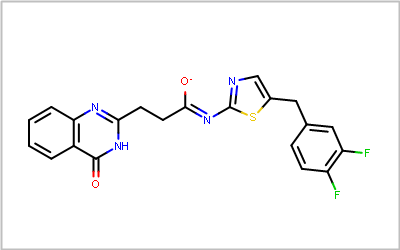
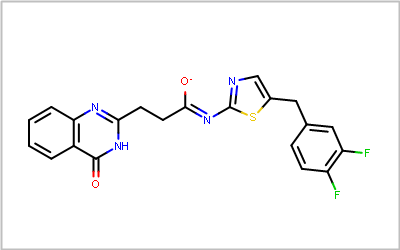
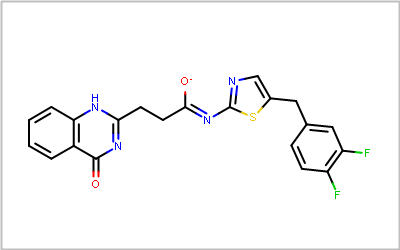
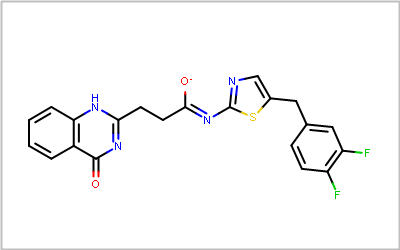
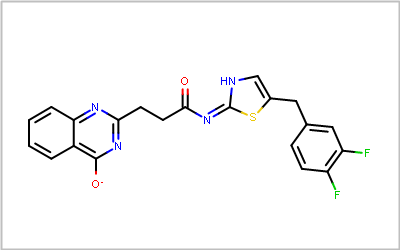
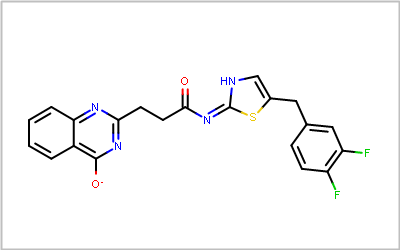
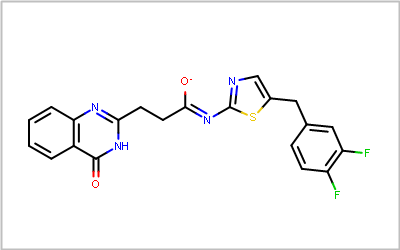
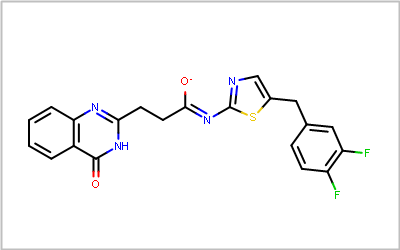
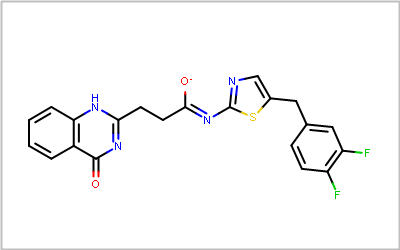
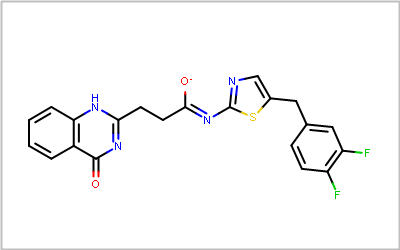
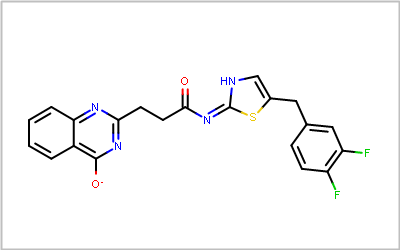
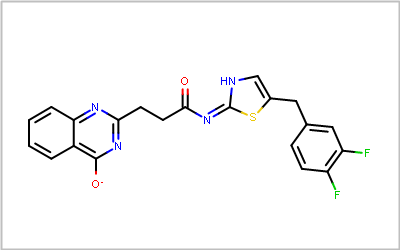
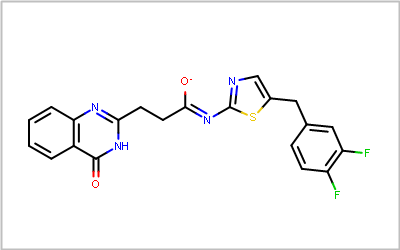
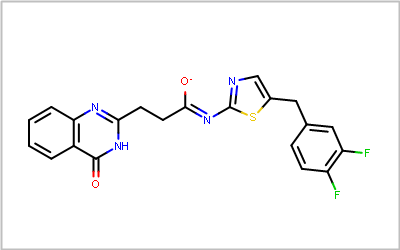
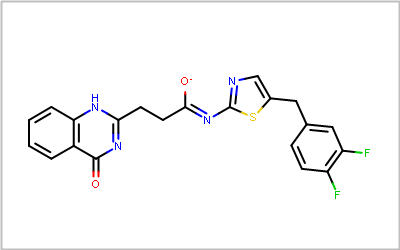
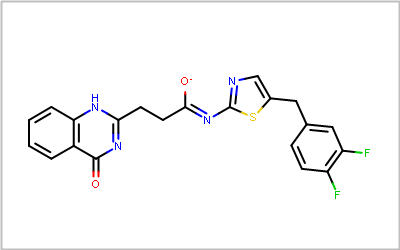
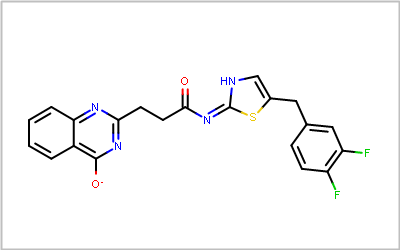
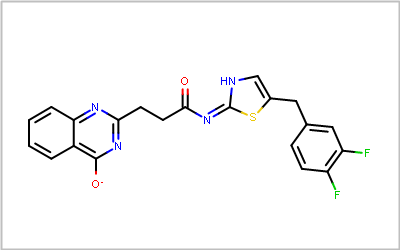
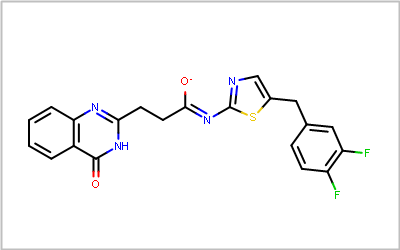
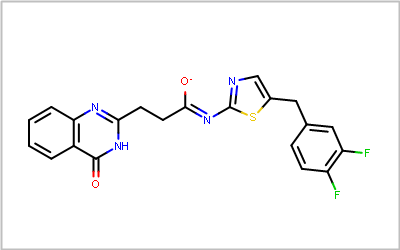
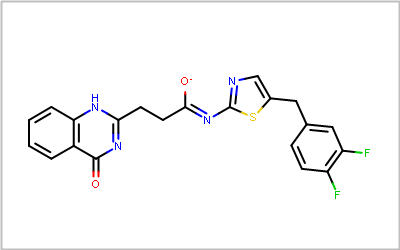
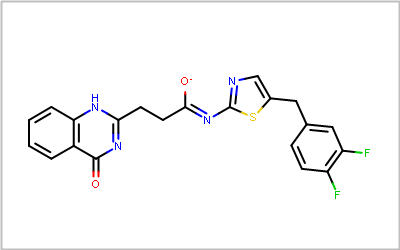
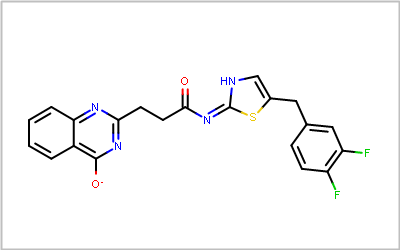
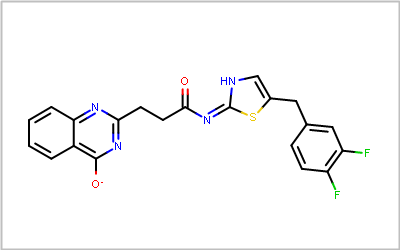
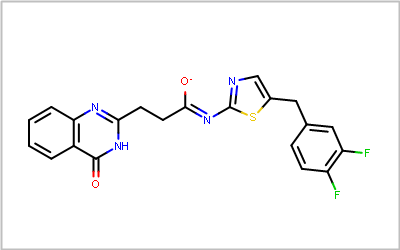
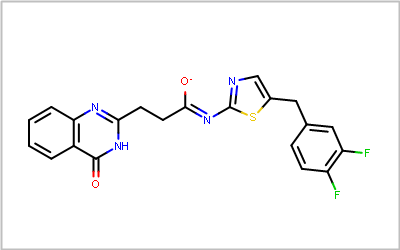
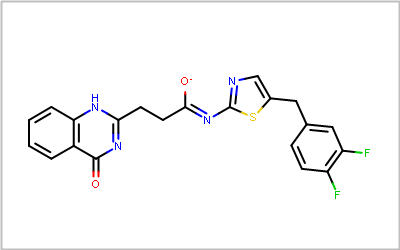
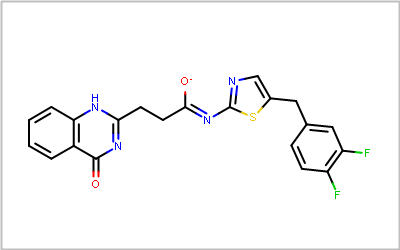
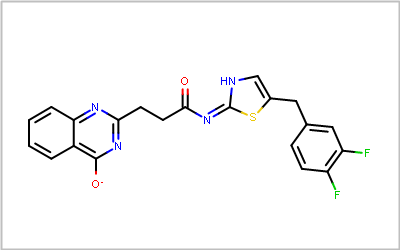
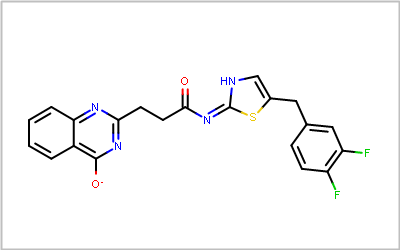
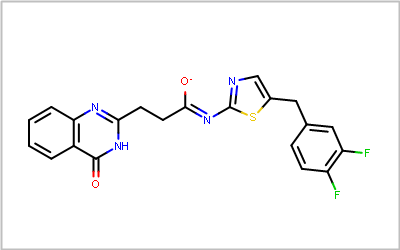
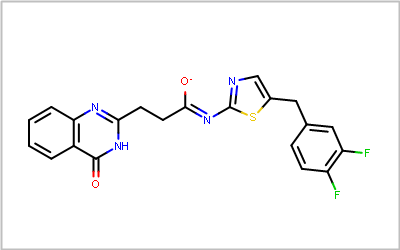
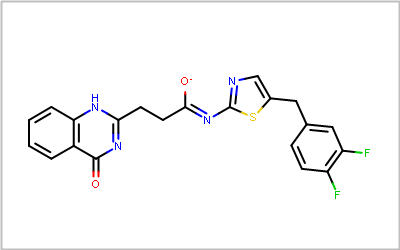
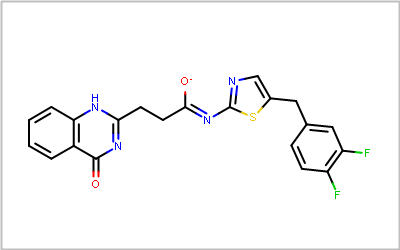
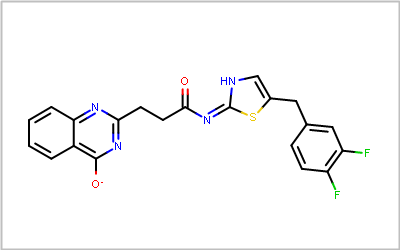
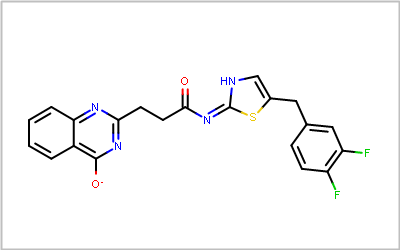
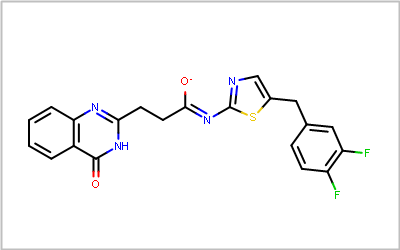
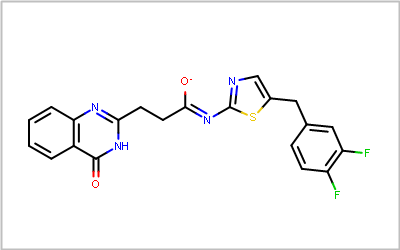
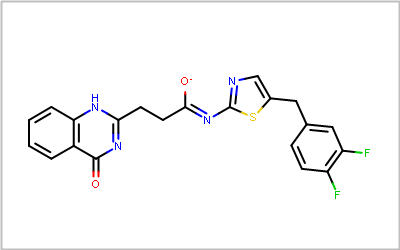
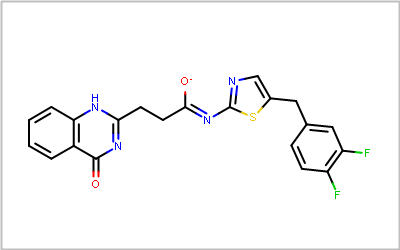
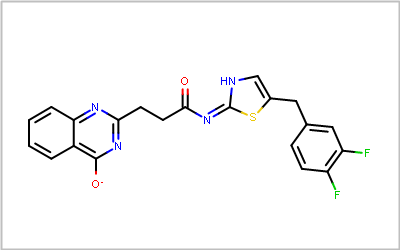
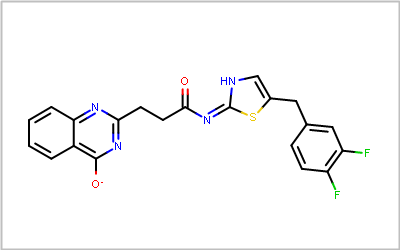
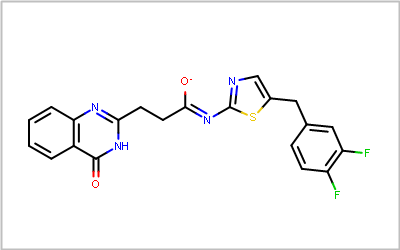
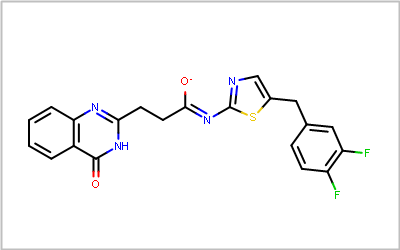
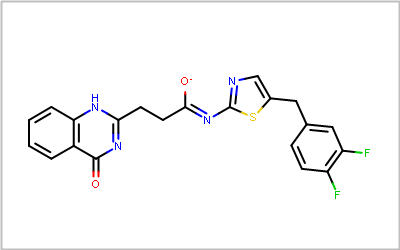
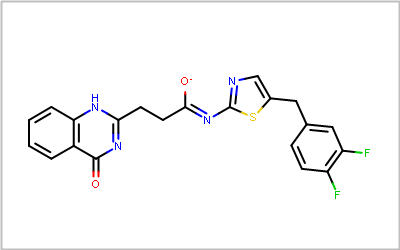
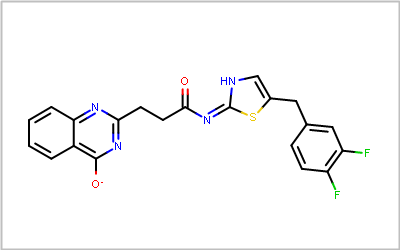
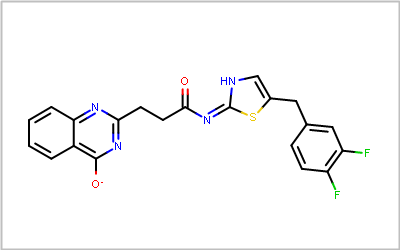
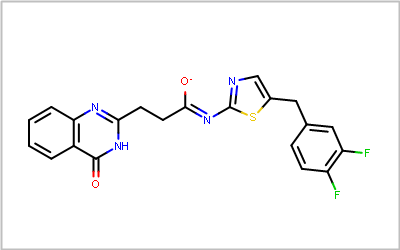
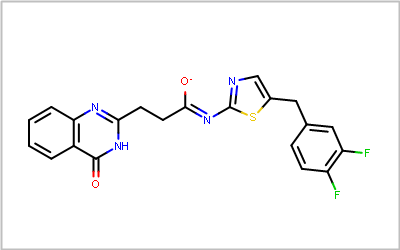
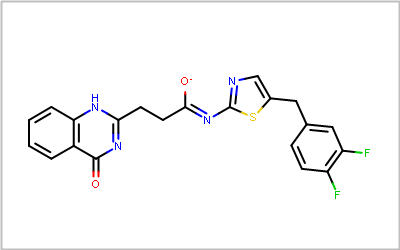
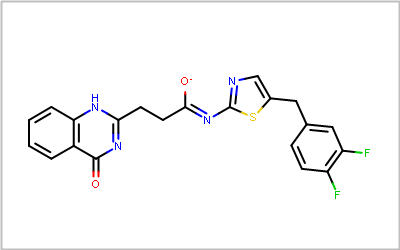
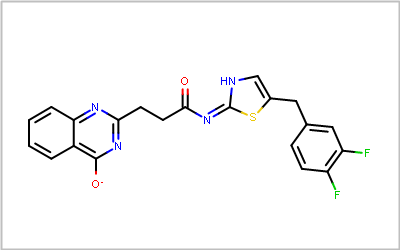
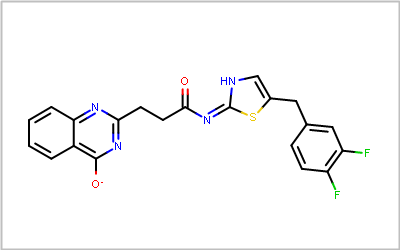
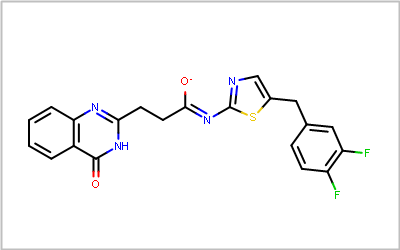
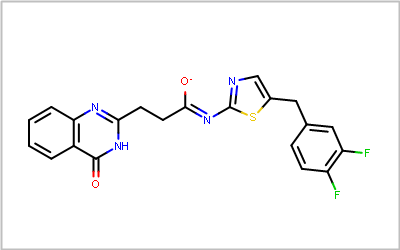
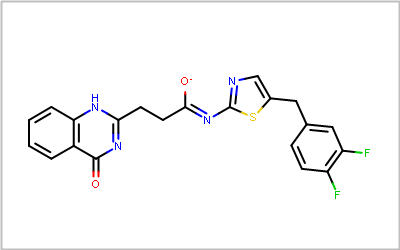
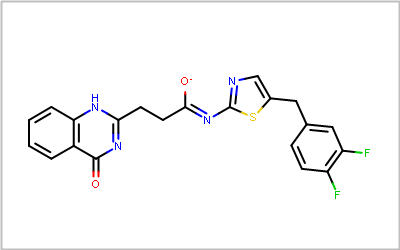
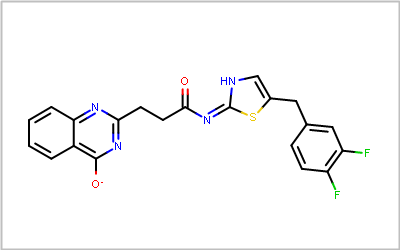
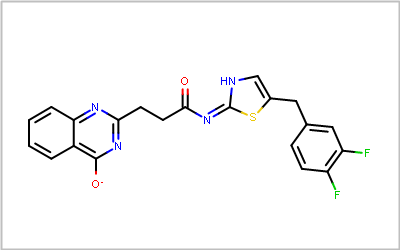
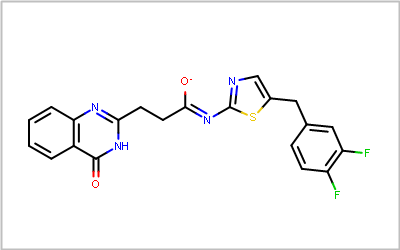
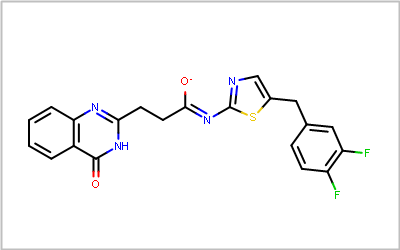
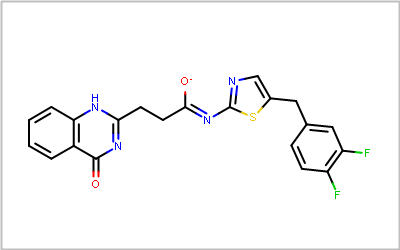
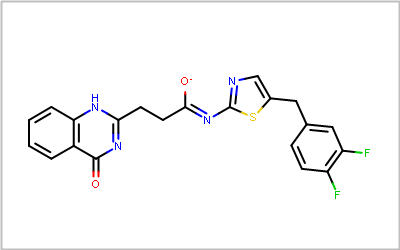
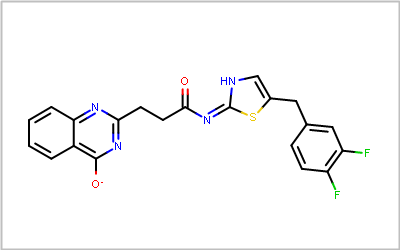
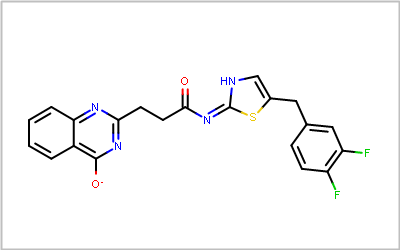
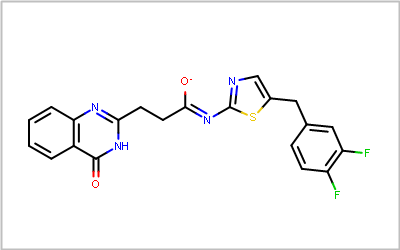
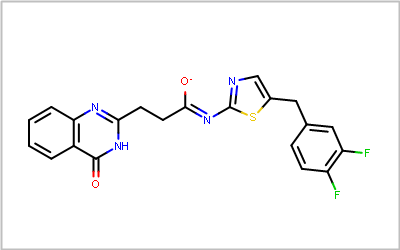
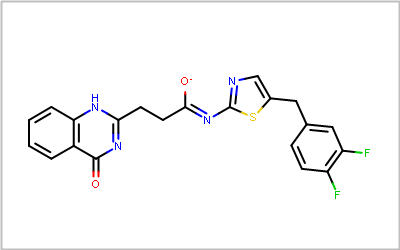
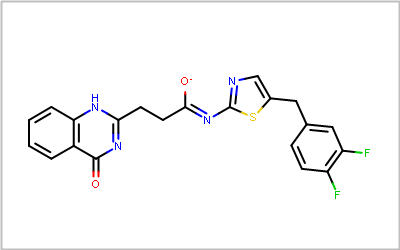
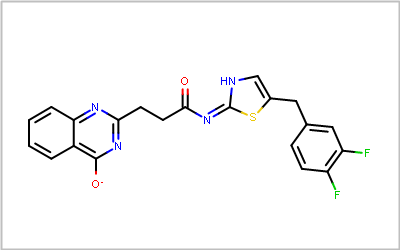
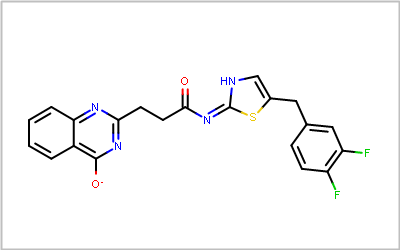
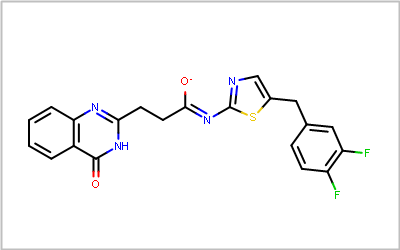
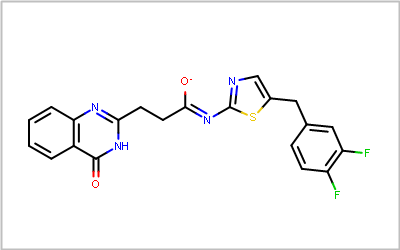
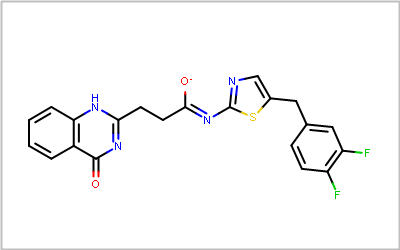
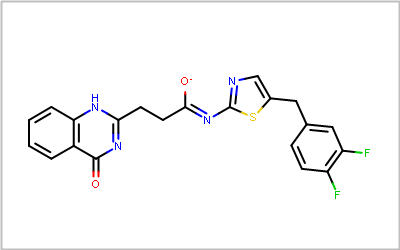
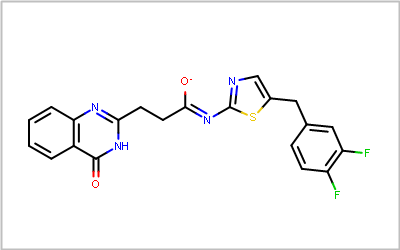
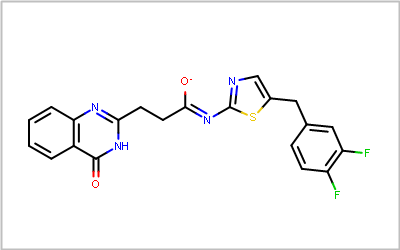
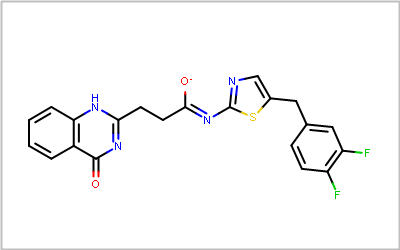
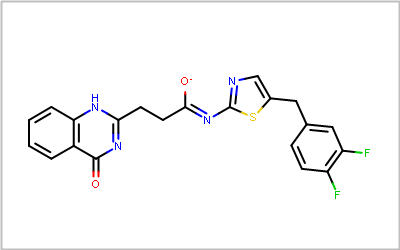
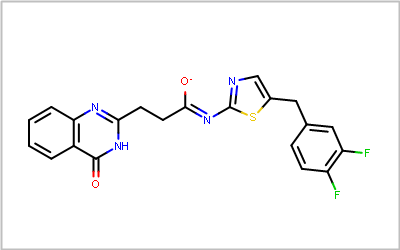
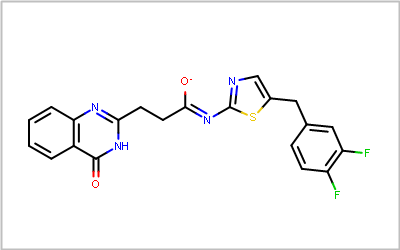
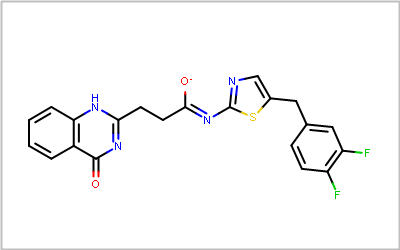
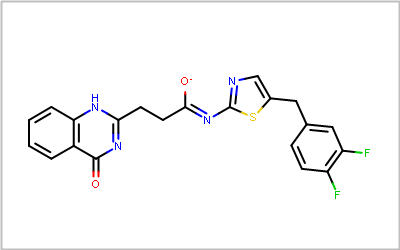
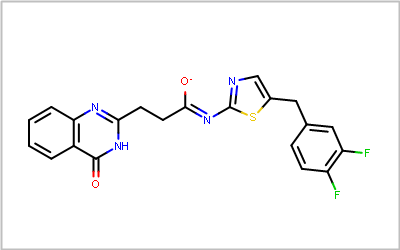
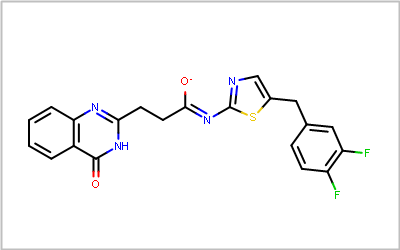
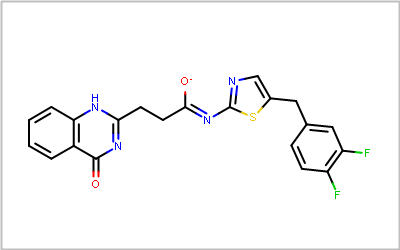
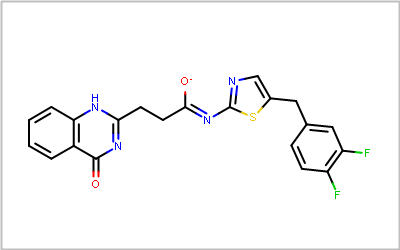
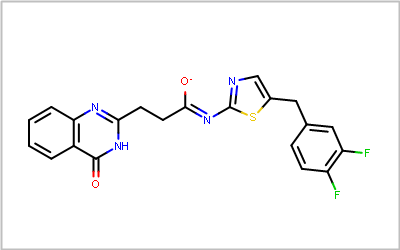
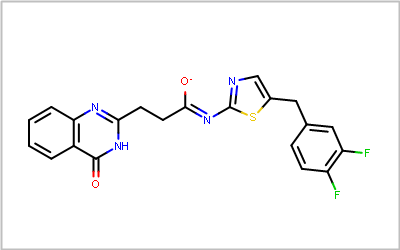
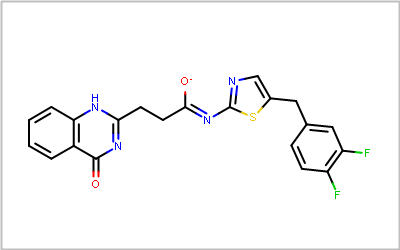
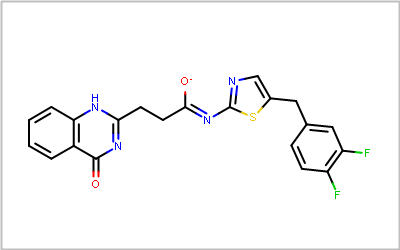
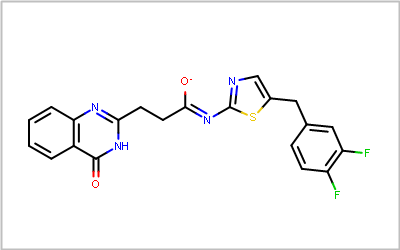
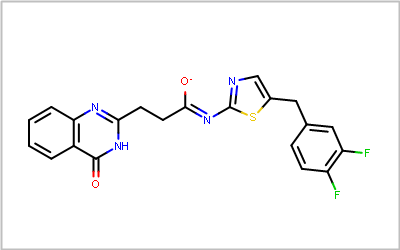
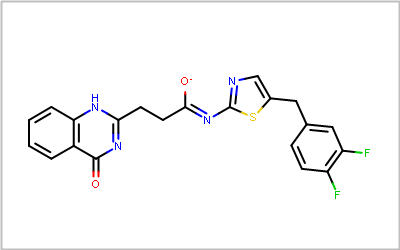
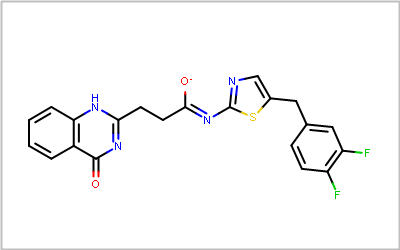
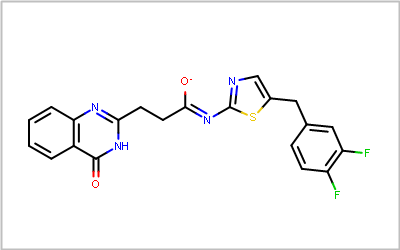
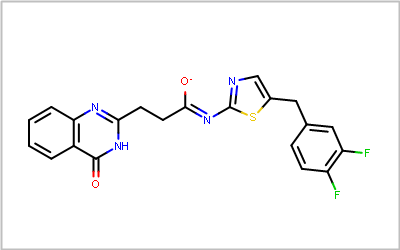
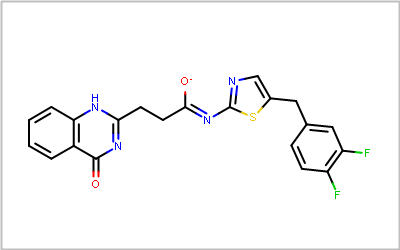
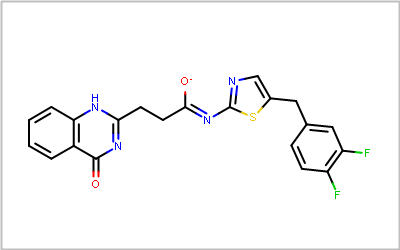
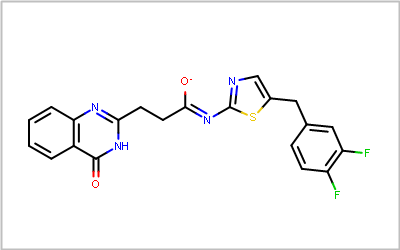
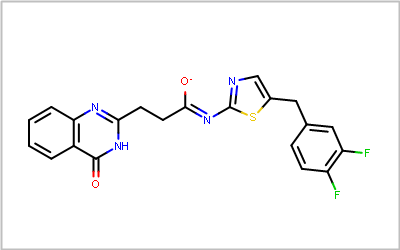
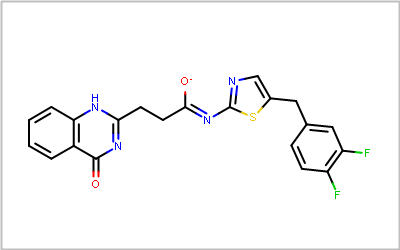
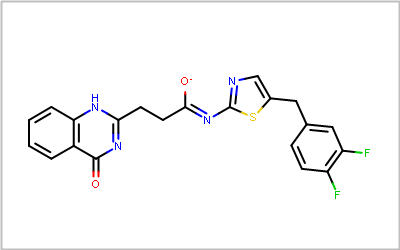
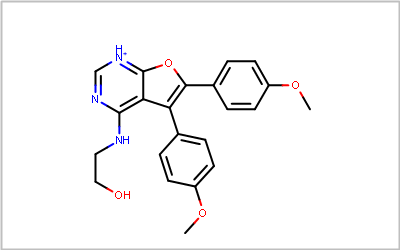
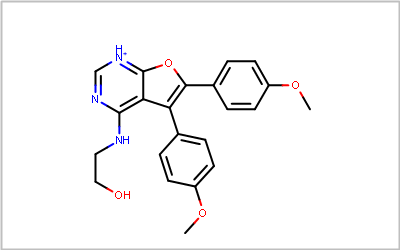
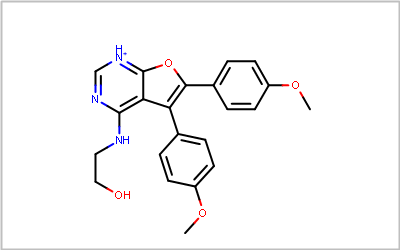
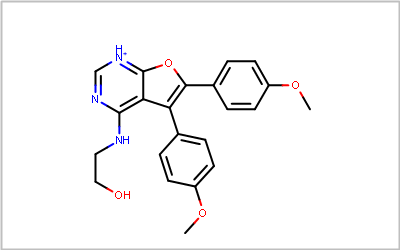
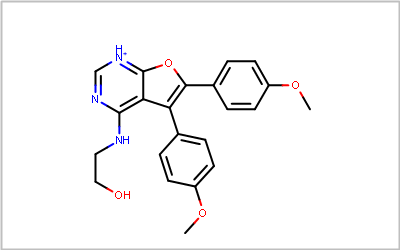
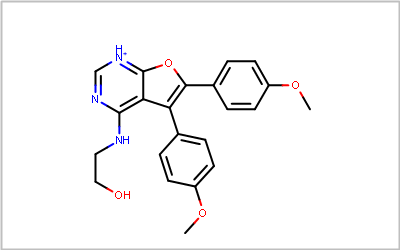
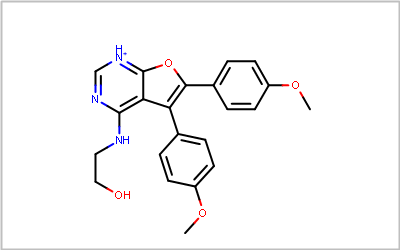
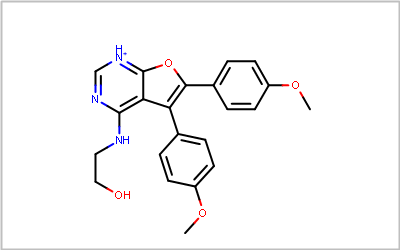
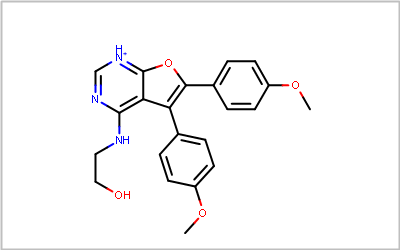
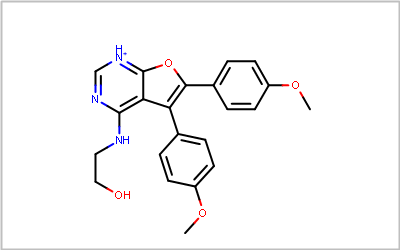
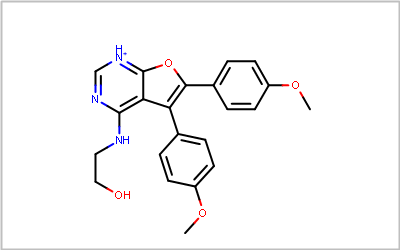
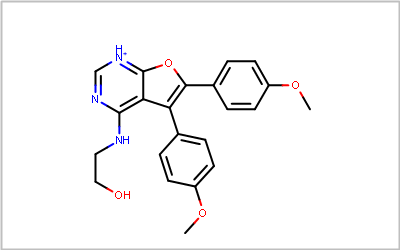
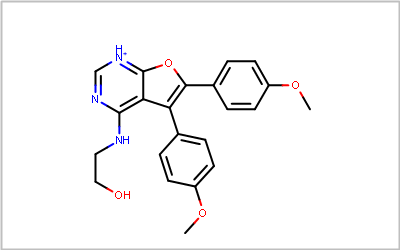
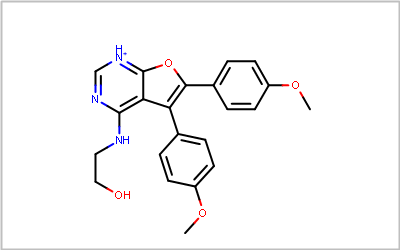
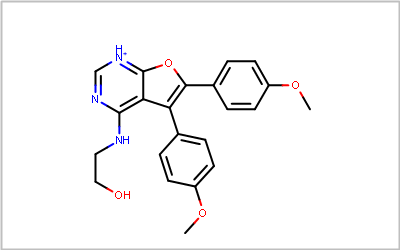
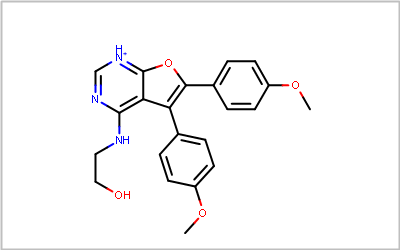
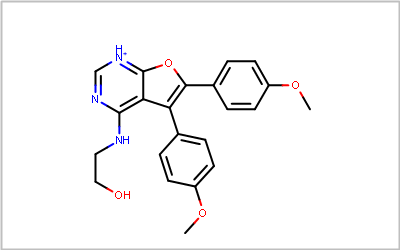
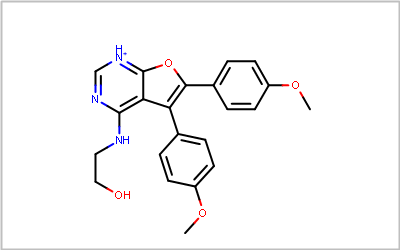
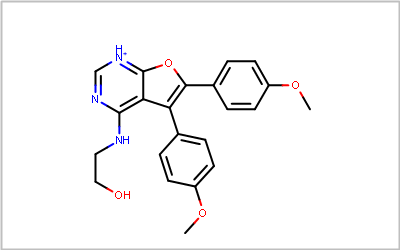
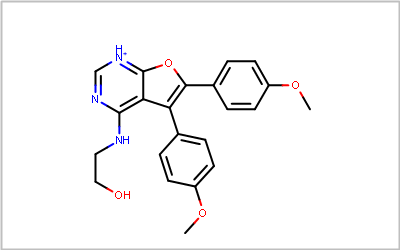
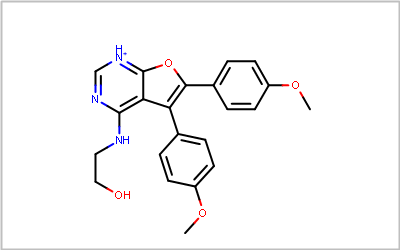
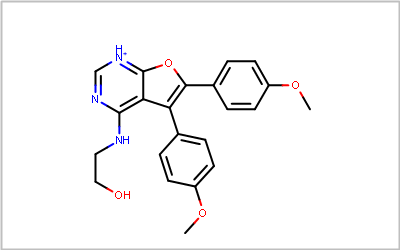
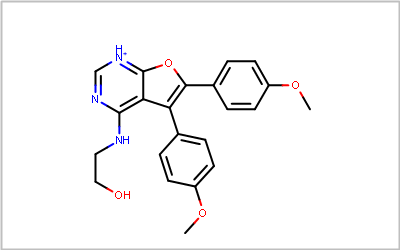
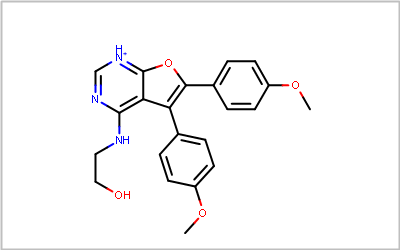
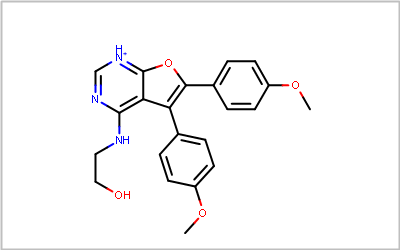
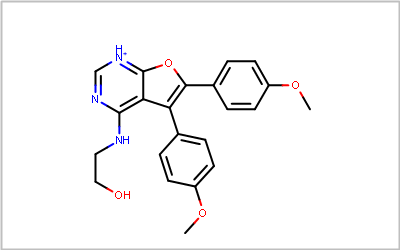
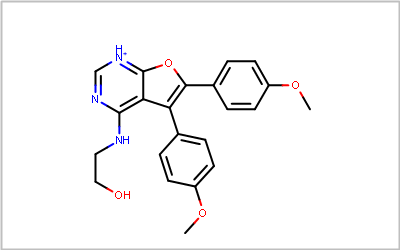
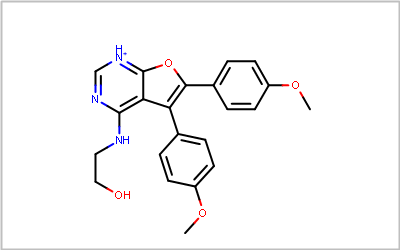
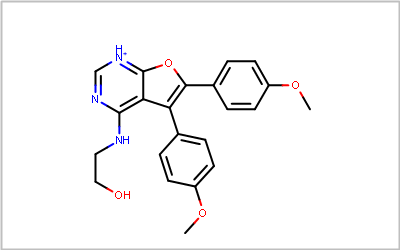
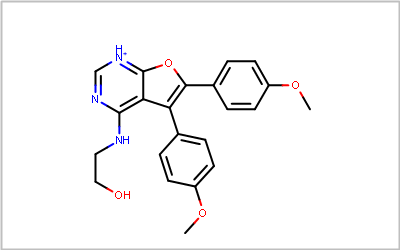
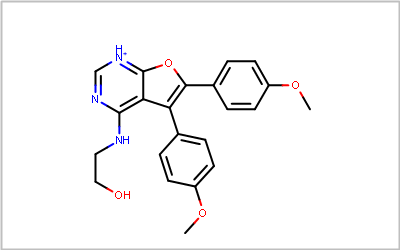
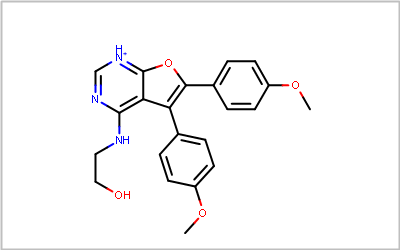
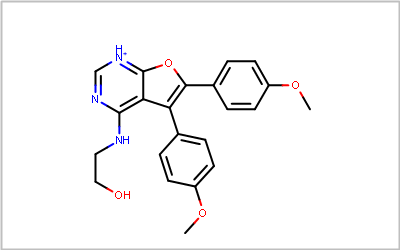
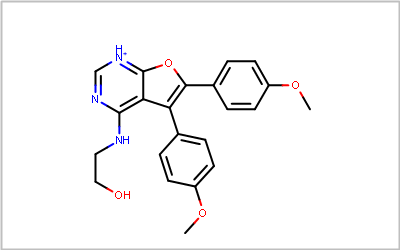
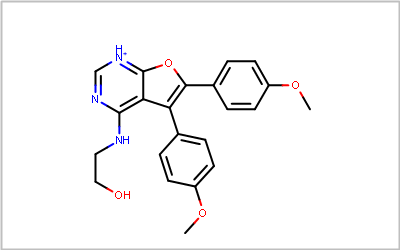
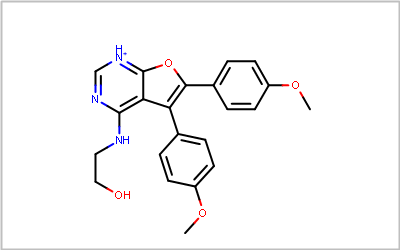
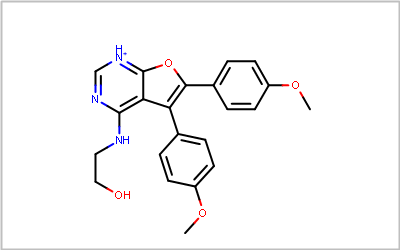
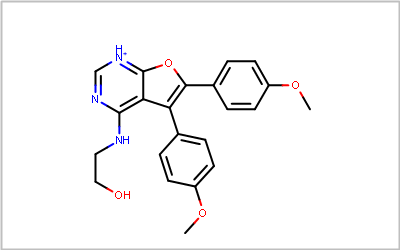
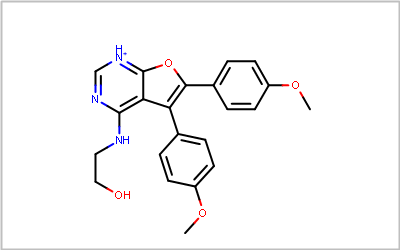
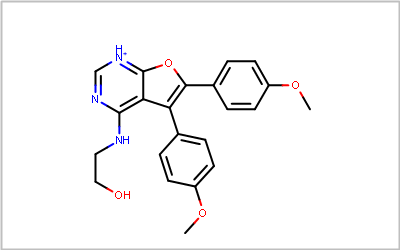
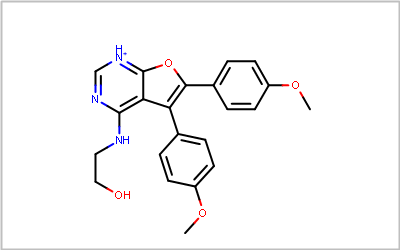
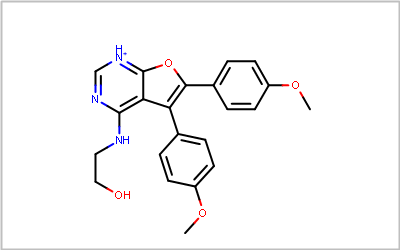
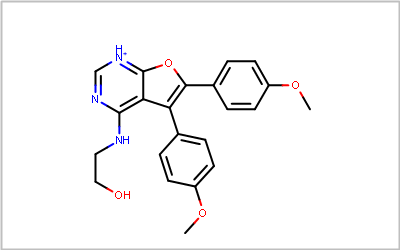
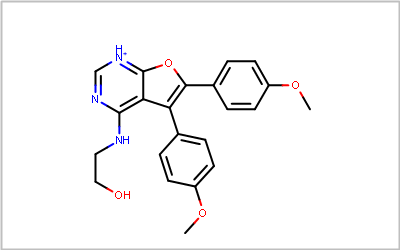
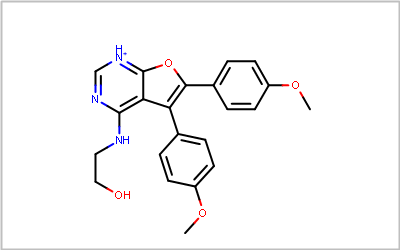
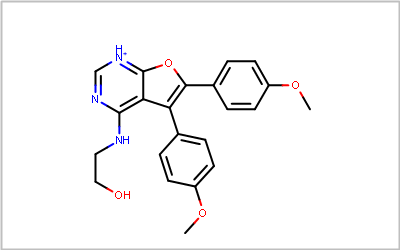
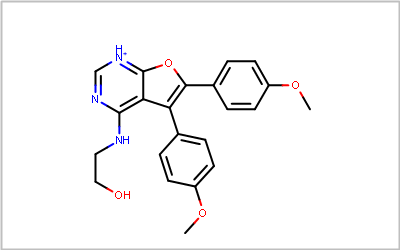
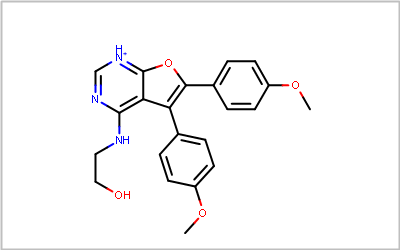
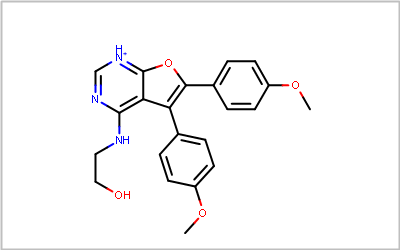
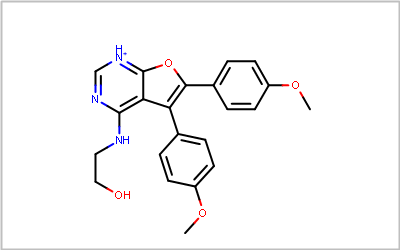
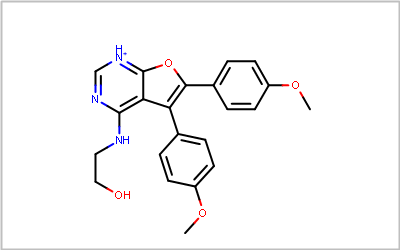
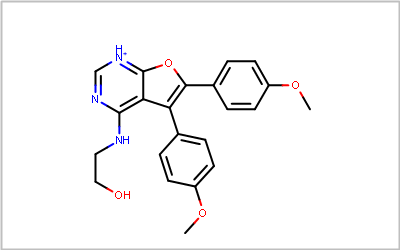
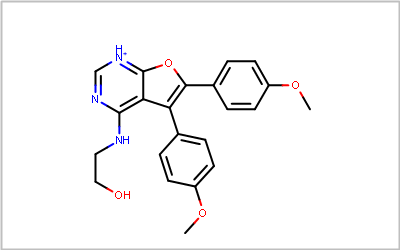
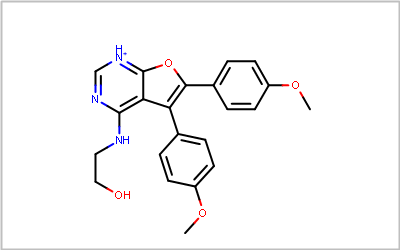
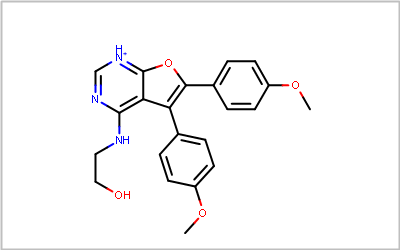
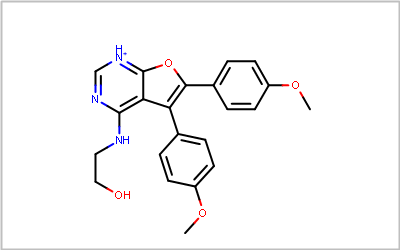
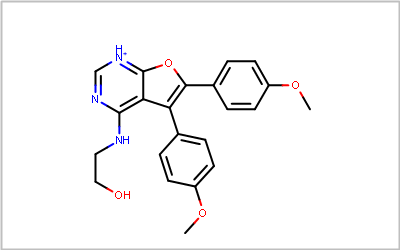
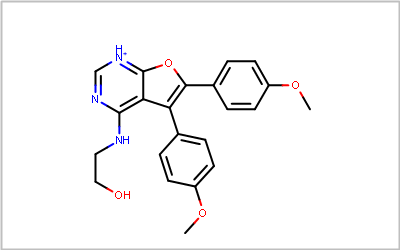
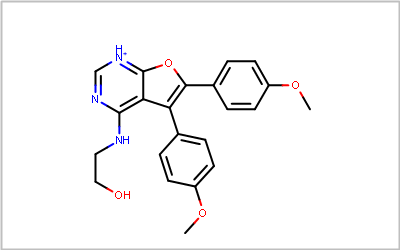
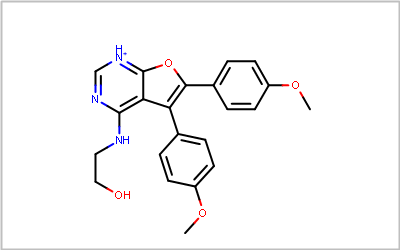
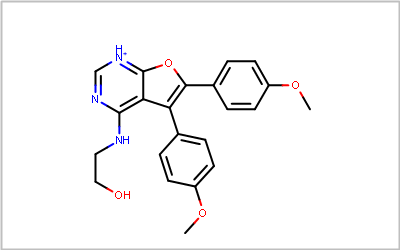
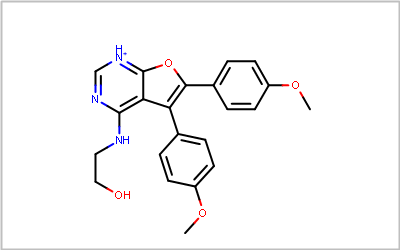
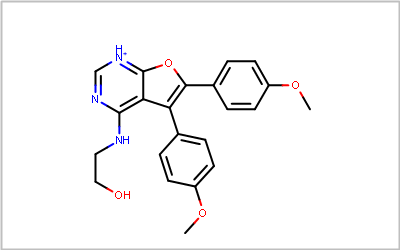
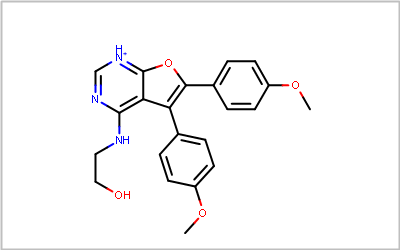
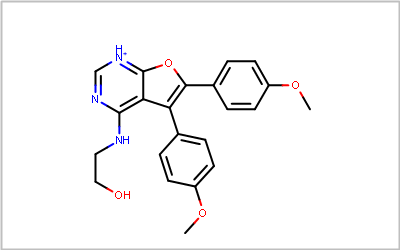
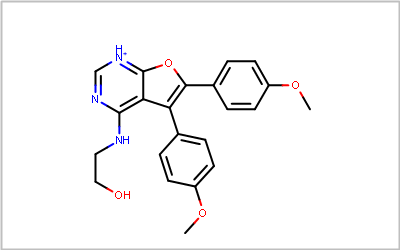
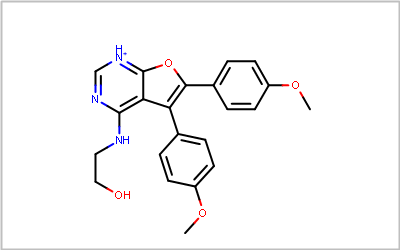
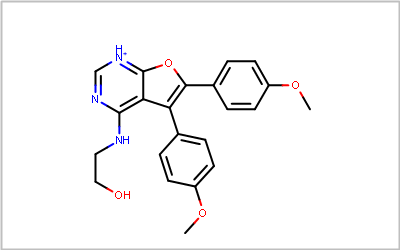
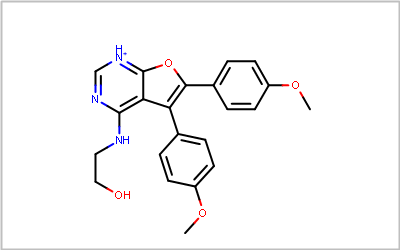
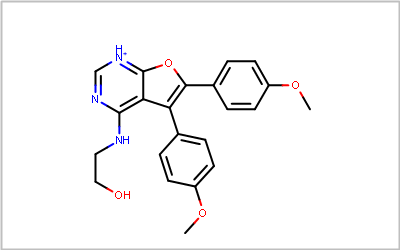
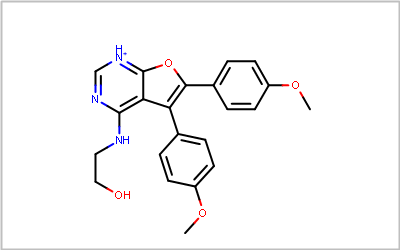
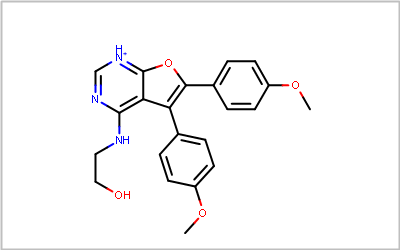
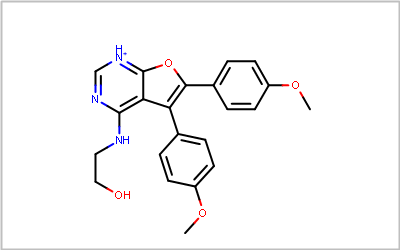
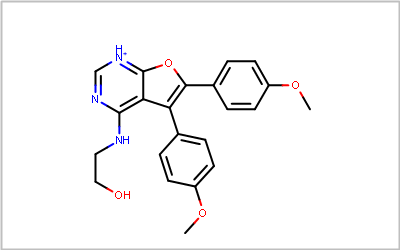
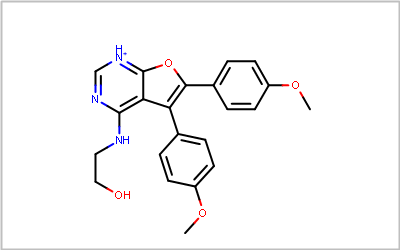
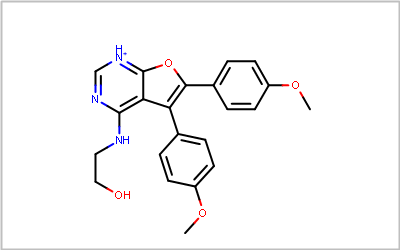
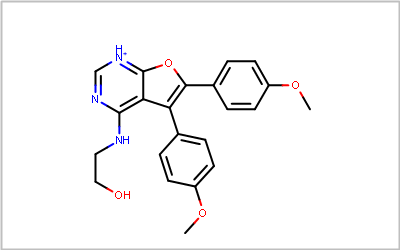
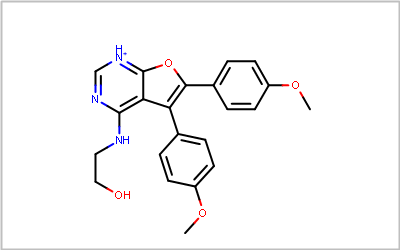
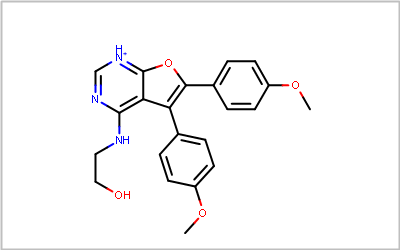
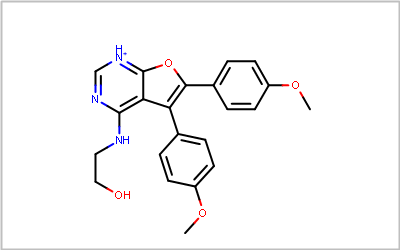
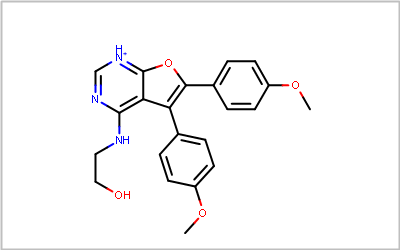
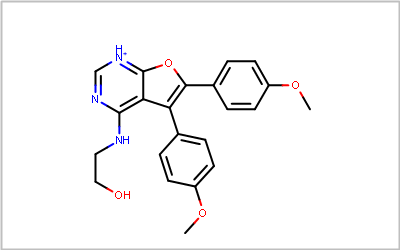
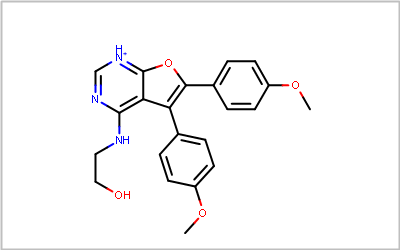
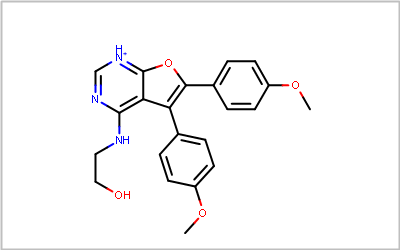
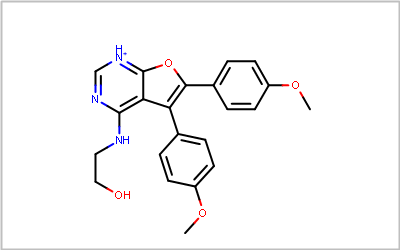
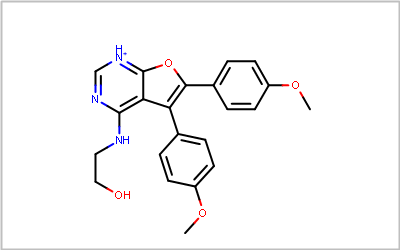
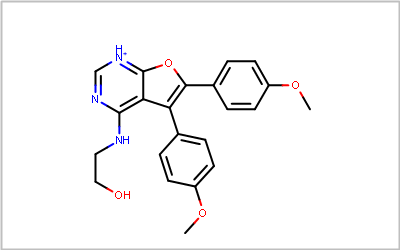
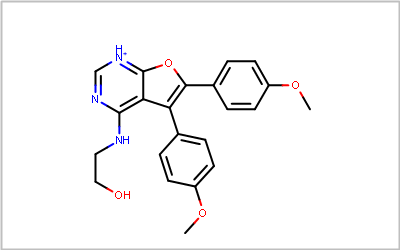
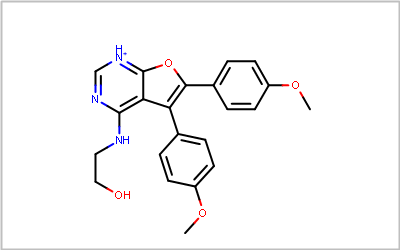
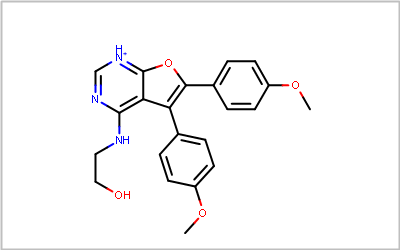
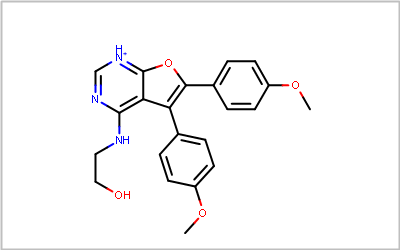
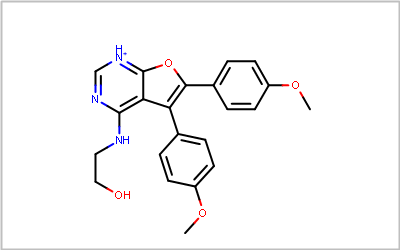

In [131]:
# If multiple sampl states match one predicted state. This should always be empty, if the SAMPL states are defined right
sampl_state_duplicates = matched_states.duplicated(["pH", "SAMPL6_ID", "Epik_Microstate"], keep=False)
print("Duplicated by SAMPL",len(matched_states[sampl_state_duplicates]) )

# Epik can produce the same state twice (if arrived at from a different micro pKa)
# Or, if arrived at through a different tautomer. In the first case, both states have the same energy
# in the latter, they wont.
epik_state_duplicates = matched_states.duplicated(["pH", "SAMPL6_ID", "SAMPL6_Microstate_ID"], keep=False)
epik_state_duplicates_with_same_energy = matched_states.duplicated(["pH", "SAMPL6_ID", "SAMPL6_Microstate_ID", "Log_P"], keep=False)

print("Duplicated by Epik", len(matched_states[epik_state_duplicates]))
print("Duplicated states with different tautomer energy: {}".format(len(matched_states[epik_state_duplicates])-len(matched_states[epik_state_duplicates_with_same_energy])))

oenb.render_dataframe(matched_states[epik_state_duplicates], mol_col="SAMPL6_Molecule")



In [135]:
matched_states.to_csv(open("microscopic_to_sampl6_mapping.csv", "w"), columns=["SAMPL6_ID", "pH", "Epik_Microstate", "SAMPL6_Microstate_ID", "Log_P"])
# For type 2 analysis, we pick the lowest energy state, and drop all other duplicates
matched_states = matched_states.drop_duplicates(["pH", "SAMPL6_ID", "Epik_Microstate"], keep="first")

In [156]:
# shorthand
final_df = pd.DataFrame(columns = ["SAMPL6_ID", "SAMPL6_Microstate_ID", "pH", "Log_P"], )
ms = matched_states


def register_result(molecule_id, output_df, pH_array=None):
    """Register results in the final dataframe"""

    microstates = load_microstate_dictionary(molecule_id)
    for microstate in microstates.keys():
        observed = True
        if not any(ms["SAMPL6_Microstate_ID"]== microstate):            
            observed = False
            
        if pH_array is None:
            pH_array = np.linspace(2.0, 12.0, 101)
        for pH in pH_array:
            pH_str = '{:.1f}'.format(pH)
            new_entry = {"SAMPL6_ID": molecule_id, "SAMPL6_Microstate_ID": microstate, "pH" : float(pH) , "Log_P" : -10.0}
            data = ms.loc[(ms['SAMPL6_ID'] == SAMPL_ID) & (ms['SAMPL6_Microstate_ID'] == microstate) & (ms['pH'] == pH_str) ] 
            
            if len(data) > 0:               
                # In case duplicates, pick num 1                
                row = data.iloc[0]
                if observed:
                    new_entry["Log_P"] = row["Log_P"]                

            output_df = output_df.append(new_entry, ignore_index=True)
    return output_df

for molecule in range(24):
    SAMPL_ID = "SM{:02d}".format(molecule+1)
    final_df = register_result(SAMPL_ID, final_df)
    
    
final_df

SAMPL6_ID SAMPL6_Microstate_ID    pH      Log_P
0          SM01        SM01_micro001   2.0  -6.095684
1          SM01        SM01_micro001   2.1  -6.340923
2          SM01        SM01_micro001   2.2  -6.586330
3          SM01        SM01_micro001   2.3  -6.831737
4          SM01        SM01_micro001   2.4  -7.077144
5          SM01        SM01_micro001   2.5  -7.322720
6          SM01        SM01_micro001   2.6  -7.568296
7          SM01        SM01_micro001   2.7  -7.813872
8          SM01        SM01_micro001   2.8  -8.059448
9          SM01        SM01_micro001   2.9  -8.305024
10         SM01        SM01_micro001   3.0  -8.550769
11         SM01        SM01_micro001   3.1  -8.796344
12         SM01        SM01_micro001   3.2  -9.042089
13         SM01        SM01_micro001   3.3  -9.287834
14         SM01        SM01_micro001   3.4  -9.533410
15         SM01        SM01_micro001   3.5  -9.779155
16         SM01        SM01_micro001   3.6 -10.000000
17         SM01        SM01_micro001   3.7 -10.000000
18         SM01        SM01_micro001   3.8 -10.000000
19         SM01        SM01_micro001   3.9 -10.000000
20         SM01        SM01_micro001   4.0 -10.000000
21         SM01        SM01_micro001   4.1 -10.000000
22         SM01        SM01_micro001   4.2 -10.000000
23         SM01        SM01_micro001   4.3 -10.000000
24         SM01        SM01_micro001   4.4 -10.000000
25         SM01        SM01_micro001   4.5 -10.000000
26         SM01        SM01_micro001   4.6 -10.000000
27         SM01        SM01_micro001   4.7 -10.000000
28         SM01        SM01_micro001   4.8 -10.000000
29         SM01        SM01_micro001   4.9 -10.000000
...         ...                  ...   ...        ...
35522      SM24        SM24_micro035   9.1 -10.000000
35523      SM24        SM24_micro035   9.2 -10.000000
35524      SM24        SM24_micro035   9.3 -10.000000
35525      SM24        SM24_micro035   9.4 -10.000000
35526      SM24        SM24_micro035   9.5 -10.000000
35527      SM24        SM24_micro035   9.6 -10.000000
35528      SM24        SM24_micro035   9.7 -10.000000
35529      SM24        SM24_micro035   9.8 -10.000000
35530      SM24        SM24_micro035   9.9 -10.000000
35531      SM24        SM24_micro035  10.0 -10.000000
35532      SM24        SM24_micro035  10.1 -10.000000
35533      SM24        SM24_micro035  10.2 -10.000000
35534      SM24        SM24_micro035  10.3 -10.000000
35535      SM24        SM24_micro035  10.4 -10.000000
35536      SM24        SM24_micro035  10.5 -10.000000
35537      SM24        SM24_micro035  10.6 -10.000000
35538      SM24        SM24_micro035  10.7 -10.000000
35539      SM24        SM24_micro035  10.8 -10.000000
35540      SM24        SM24_micro035  10.9 -10.000000
35541      SM24        SM24_micro035  11.0 -10.000000
35542      SM24        SM24_micro035  11.1 -10.000000
35543      SM24        SM24_micro035  11.2 -10.000000
35544      SM24        SM24_micro035  11.3 -10.000000
35545      SM24        SM24_micro035  11.4 -10.000000
35546      SM24        SM24_micro035  11.5 -10.000000
35547      SM24        SM24_micro035  11.6 -10.000000
35548      SM24        SM24_micro035  11.7 -10.000000
35549      SM24        SM24_micro035  11.8 -10.000000
35550      SM24        SM24_micro035  11.9 -10.000000
35551      SM24        SM24_micro035  12.0 -10.000000

[35552 rows x 4 columns]

In [157]:
typeII = final_df.pivot(values="Log_P", index="SAMPL6_Microstate_ID", columns="pH")

In [158]:
typeII.to_csv(open("typeII-raw-microscopic.csv", "w"))

In [155]:
type(final_df.iloc[16]['Log_P'])

str